# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão
- [ ] Checar quebra estrutural em 1991

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html		SeriesTemporais.Rproj	VECM_Infla.pdf
Benchmark.ipynb		tabs			VECM_Infla.py
Benchmark.pdf		tese_Lucas.xls		VECM_TxPropria.html
Benchmark.Rmd		Teste.ipynb		VECM_TxPropria.ipynb
Clean-checkpoint.ipynb	VECM_Infla.html		VECM_TxPropria_media.ipynb
Clean.ipynb		VECM_Infla.ipynb	VECM_TxPropria.pdf
figs			VECM_Infla_media.ipynb	VECM_TxPropria.py


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
#start = datetime.datetime(1992, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

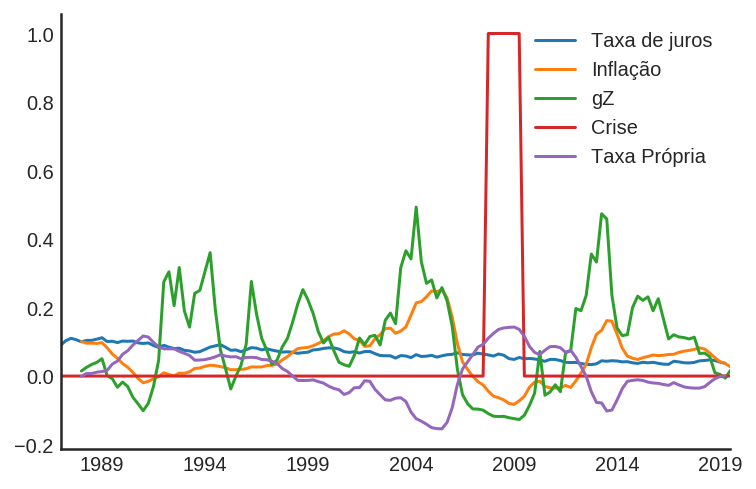

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
2018-06-30,0.0455,0.078843,0.066893,0,-0.030906,0.004282,0.001012,-0.003647,0.0011
2018-09-30,0.0472,0.067097,0.056555,0,-0.018646,0.012260,-0.010338,-0.011746,0.0017
2018-12-31,0.0455,0.053553,0.009721,0,-0.007644,0.011002,-0.046833,-0.013544,-0.0017
2019-03-31,0.0406,0.041908,0.004754,0,-0.001255,0.006388,-0.004968,-0.011645,-0.0049
2019-06-30,0.0373,0.036667,-0.006007,0,0.000610,0.001866,-0.010761,-0.005241,-0.0033


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df = df.resample('Q').last()  ##### Warning!!!!
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"], *_ = yeojohnson(df["Preço dos imóveis"].pct_change(4)) ### Warning: 1

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
#df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1


df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.tail()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=1,) ### Warning: 1
        print(result.summary())
        print(f'Para lag = {i}, Rank = {result.rank}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1]
    conclusion = result < signif
    for j in range(k):
      print(f'p-value = {result[j]}')
      print("Reject H0 on lag " ,j+1,"? ", conclusion[j], "\n")
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

# Teste de quebra estrutural

In [8]:
%%R -i df
library(strucchange)
library(urca)
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- ts(data = df, start = c(1987,01), frequency = 4)
bp_ts <- breakpoints(Juros ~ 1, data=df)
print("Testando quebra estrutural para Taxa de juros das hipotecas")
print(summary(bp_ts))

bp_ts <- breakpoints(gZ ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa de crescimento dos imóveis")
print(summary(bp_ts))

bp_ts <- breakpoints(TaxaP ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa Própria")
print(summary(bp_ts))

bp_ts <- breakpoints(Infla ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Inflação")
print(summary(bp_ts))

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



[1] "Testando quebra estrutural para Taxa de juros das hipotecas"

	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = Juros ~ 1, data = df)

Breakpoints at observation number:
                      
m = 1            78   
m = 2            67 85
m = 3   18       67 85
m = 4   18 36    67 85
m = 5   18 36 54 73 91

Corresponding to breakdates:
                                               
m = 1                           2006(2)        
m = 2                           2003(3) 2008(1)
m = 3   1991(2)                 2003(3) 2008(1)
m = 4   1991(2) 1995(4)         2003(3) 2008(1)
m = 5   1991(2) 1995(4) 2000(2) 2005(1) 2009(3)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS   6.608   5.957   4.278   4.278   4.278   4.278
BIC  -3.113  -6.411 -38.155 -28.499 -18.842  -9.186
[1] "========================="
[1] "Testando quebra estrutural para Taxa de crescimento dos imÃ³veis"

	 Optimal (m+1)-segment part

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
         'data',
        'juros',
        'infla',
        'gz',
        'crise',
        'propria',
        'd_propria',
        'd_gz',
        'd_infla'
        'd_juros'
          ], 
         )


# Teste de raíz unitária

## Investimento residencial ($g_Z$)

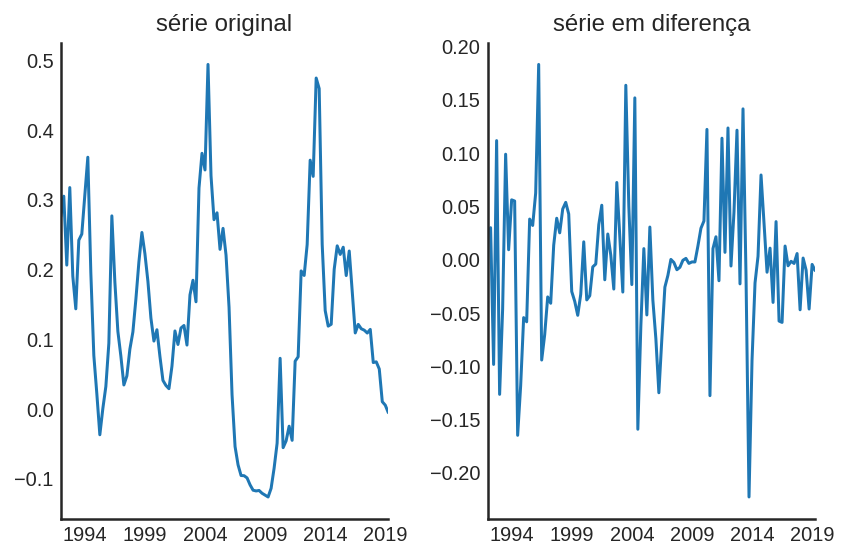

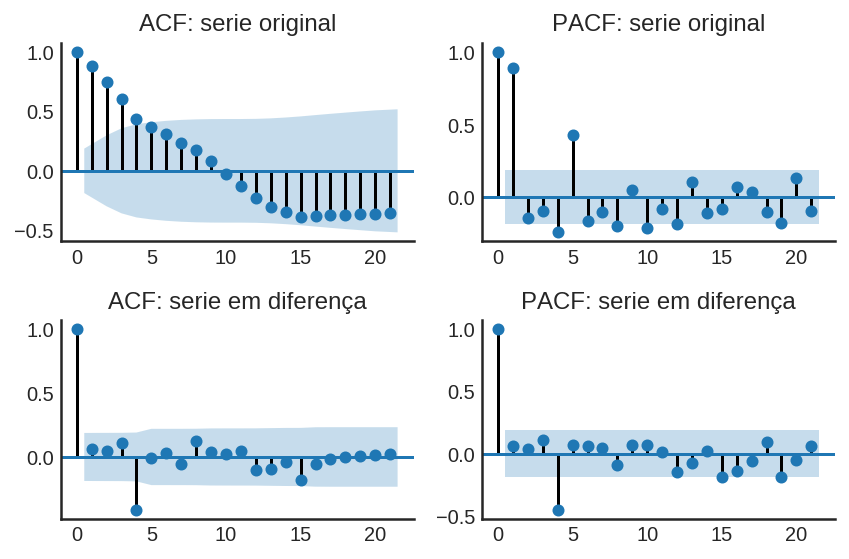


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -3.206
P-value                         0.838
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.727
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.406
P-value 

In [10]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

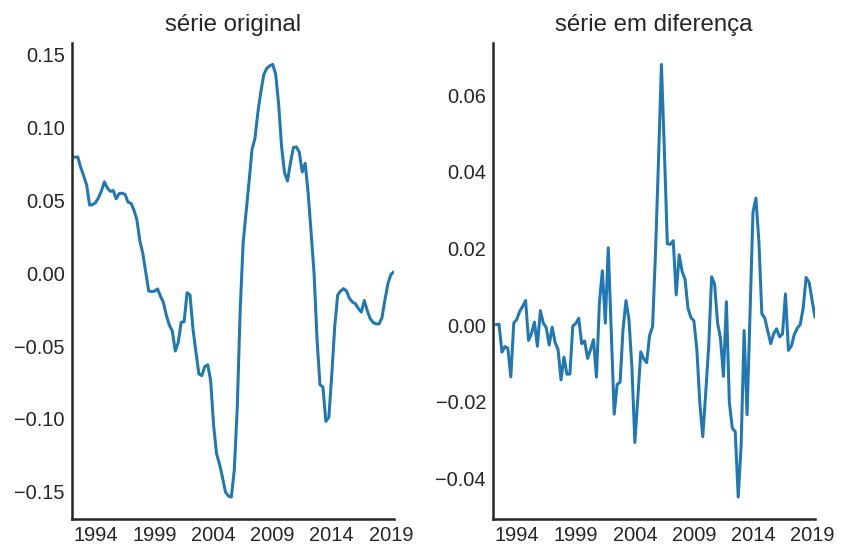

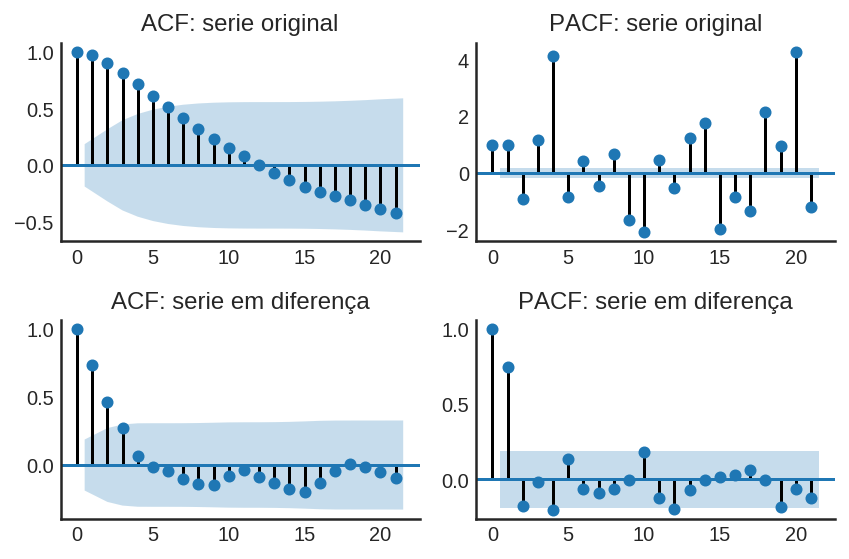


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.838
P-value                         0.004
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -4.891
P-value                         0.041
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [11]:
testes_raiz(df['Taxa Própria'], original_trend='ct', diff_trend='c') ## Warning

**Conclusão:** Será tomada em primeira diferença.

## Inflação

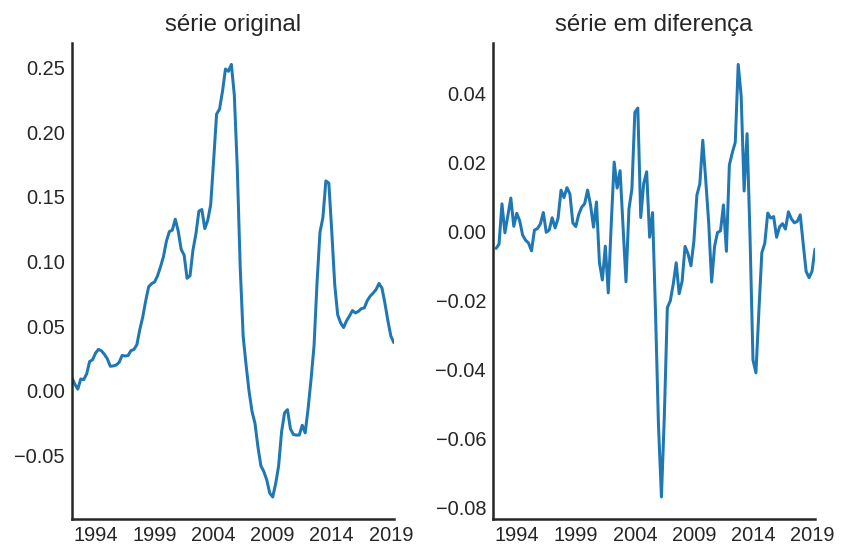

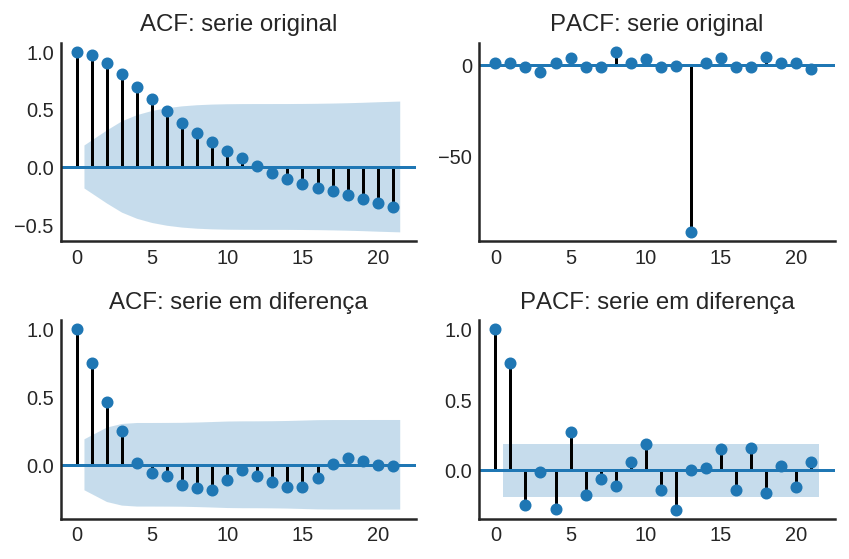


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -5.402
P-value                         0.006
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -4.512
P-value                         0.116
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.847
P-value 

In [12]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

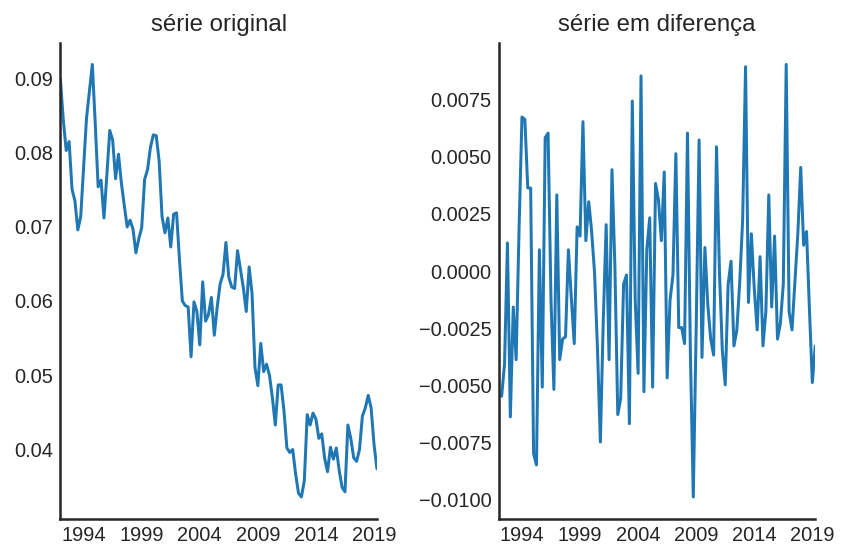

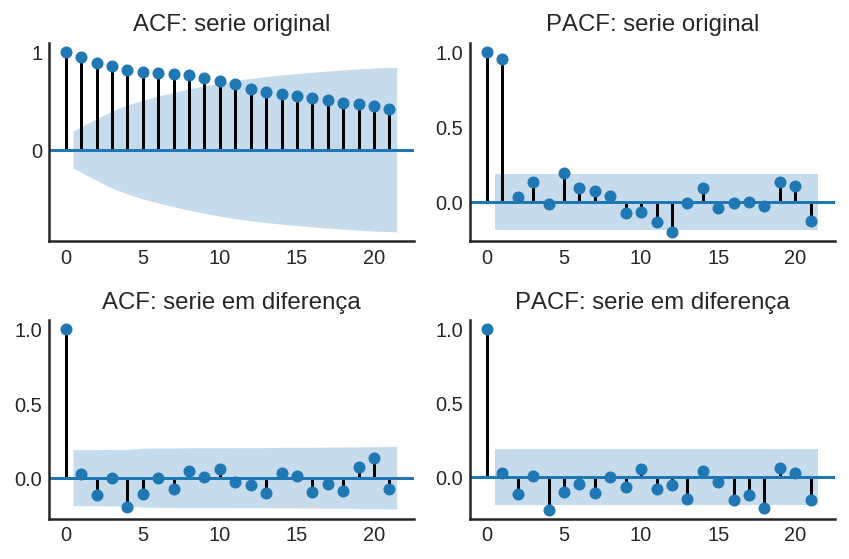


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.494
P-value                         0.215
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -8.144
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

In [14]:
print("Ordem do VAR\n")
model = VAR(
    df[["Taxa Própria", 'gZ']],
)
print(model.select_order(maxlags=15, trend='c').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.01      -9.952   4.512e-05      -9.985
1       -14.17      -14.01   7.037e-07      -14.10
2       -14.76     -14.49*   3.877e-07     -14.65*
3       -14.74      -14.36   3.966e-07      -14.59
4       -14.72      -14.24   4.037e-07      -14.53
5       -14.81      -14.22   3.703e-07      -14.57
6      -14.83*      -14.13  3.636e-07*      -14.55
7       -14.77      -13.97   3.854e-07      -14.45
8       -14.69      -13.78   4.190e-07      -14.32
9       -14.68      -13.66   4.263e-07      -14.27
10      -14.63      -13.50   4.515e-07      -14.17
11      -14.62      -13.38   4.573e-07      -14.12
12      -14.66      -13.32   4.400e-07      -14.12
13      -14.65      -13.20   4.492e-07      -14.06
14      -14.66      -13.10   4.476e-07      -14.03
15      -14.63      -12.97   4.637e-07      -13.96
-----------------

## $g_Z$ e Taxa Própria

In [15]:
testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=7)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.569213
p-value: 0.078666
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.368515
p-value: 0.045970
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.486661
p-value: 0.102329
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.464006
p-value: 0.230061
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace

## $g_Z$, Inflação e taxa de juros

In [16]:
print("Ordem do VAR\n")
model = VAR(
    df[["Taxa de juros", "Inflação", 'gZ']],
)
print(model.select_order(maxlags=15, trend='c').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.31      -18.23   1.114e-08      -18.28
1       -25.19      -24.87   1.150e-11      -25.06
2       -25.82     -25.25*   6.135e-12     -25.59*
3       -25.83      -25.02   6.067e-12      -25.50
4       -25.74      -24.69   6.680e-12      -25.31
5       -25.83      -24.54   6.099e-12      -25.31
6      -25.94*      -24.41  5.492e-12*      -25.33
7       -25.88      -24.11   5.884e-12      -25.17
8       -25.75      -23.74   6.791e-12      -24.94
9       -25.72      -23.46   7.165e-12      -24.80
10      -25.59      -23.09   8.260e-12      -24.58
11      -25.52      -22.78   9.112e-12      -24.41
12      -25.49      -22.51   9.647e-12      -24.29
13      -25.49      -22.26   1.006e-11      -24.19
14      -25.77      -22.30   7.958e-12      -24.37
15      -25.79      -22.08   8.201e-12      -24.29
-----------------

In [17]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.158025
p-value: 0.070237
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.245000
p-value: 0.154410
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.724079
p-value: 0.008146
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.162905
p-value: 0.005495
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test stati

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.447336
p-value: 0.281004
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.454300
p-value: 0.508243
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.121790
p-value: 0.366089
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.830096
p-value: 0.203338
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% s

## $g_Z$ e Inflação

In [18]:
print("Ordem do VAR\n")
model = VAR(
    df[["Inflação", 'gZ']],
)
print(model.select_order(maxlags=15, trend='c').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.709      -9.655   6.072e-05      -9.687
1       -14.02      -13.85   8.186e-07      -13.95
2       -14.68     -14.41*   4.217e-07     -14.57*
3       -14.66      -14.28   4.298e-07      -14.51
4       -14.63      -14.14   4.453e-07      -14.43
5       -14.75      -14.16   3.944e-07      -14.51
6      -14.82*      -14.12  3.676e-07*      -14.54
7       -14.75      -13.94   3.947e-07      -14.42
8       -14.68      -13.77   4.237e-07      -14.31
9       -14.64      -13.62   4.416e-07      -14.23
10      -14.60      -13.47   4.651e-07      -14.14
11      -14.57      -13.34   4.781e-07      -14.07
12      -14.57      -13.23   4.823e-07      -14.03
13      -14.60      -13.15   4.717e-07      -14.01
14      -14.59      -13.03   4.781e-07      -13.96
15      -14.57      -12.90   4.964e-07      -13.89
-----------------

In [19]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.226547
p-value: 0.014248
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.251846
p-value: 0.061677
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.245875
p-value: 0.169483
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.210497
p-value: 0.346168
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          13.35          18.40
-------------------------------------
Para lag = 7, Rank = 0


# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [20]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'ci'
order_vec = select_order(
    df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det, 
    #seasons=4,
)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-14.10,-13.89,7.498e-07,-14.02
1,-14.70,-14.37*,4.136e-07,-14.57*
2,-14.68,-14.24,4.236e-07,-14.50
3,-14.66,-14.12,4.311e-07,-14.44
4,-14.75,-14.10,3.953e-07,-14.48
5,-14.77*,-14.01,3.864e-07*,-14.46
6,-14.71,-13.85,4.103e-07,-14.36
7,-14.63,-13.66,4.466e-07,-14.24
8,-14.62,-13.54,4.530e-07,-14.18
9,-14.56,-13.37,4.811e-07,-14.08


## Estimação

In [21]:
model = VECM(
    endog = df[[
        #"Inflação", 
        "Taxa Própria", 
        "gZ"
    ]], 
    #exog=df[["Taxa de juros"]],
    #k_ar_diff=1,
    #k_ar_diff=2,
    #k_ar_diff=3,
    #k_ar_diff=4,
    k_ar_diff=5,
    #k_ar_diff=6,
    #k_ar_diff=7,
    #k_ar_diff=8,
    deterministic=det, 
    #seasons=4,
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.Taxa Própria     0.7894      0.100      7.863      0.000       0.593       0.986
L1.gZ              -0.0486      0.020     -2.474      0.013      -0.087      -0.010
L2.Taxa Própria    -0.1906      0.126     -1.510      0.131      -0.438       0.057
L2.gZ              -0.0073      0.017     -0.439      0.660      -0.040       0.025
L3.Taxa Própria     0.1059      0.130      0.814      0.416      -0.149       0.361
L3.gZ              -0.0203      0.016     -1.269      0.205      -0.052       0.011
L4.Taxa Própria    -0.2880      0.129     -2.239      0.025      -0.540      -0.036
L4.gZ              -0.0048      0.016     -0.302      0.763      -0.036       0.026
L5.Taxa Própria     0.1166      0.100      1.170      0.242      -0.

## Análise dos resíduos


PÓS ESTIMAÇÂO



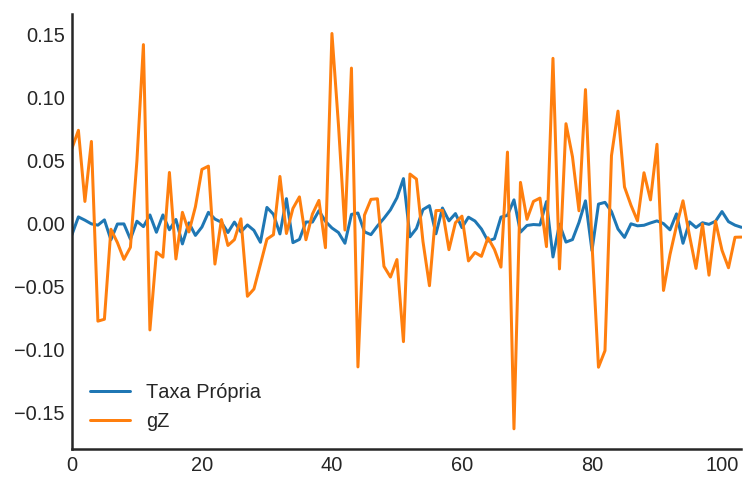

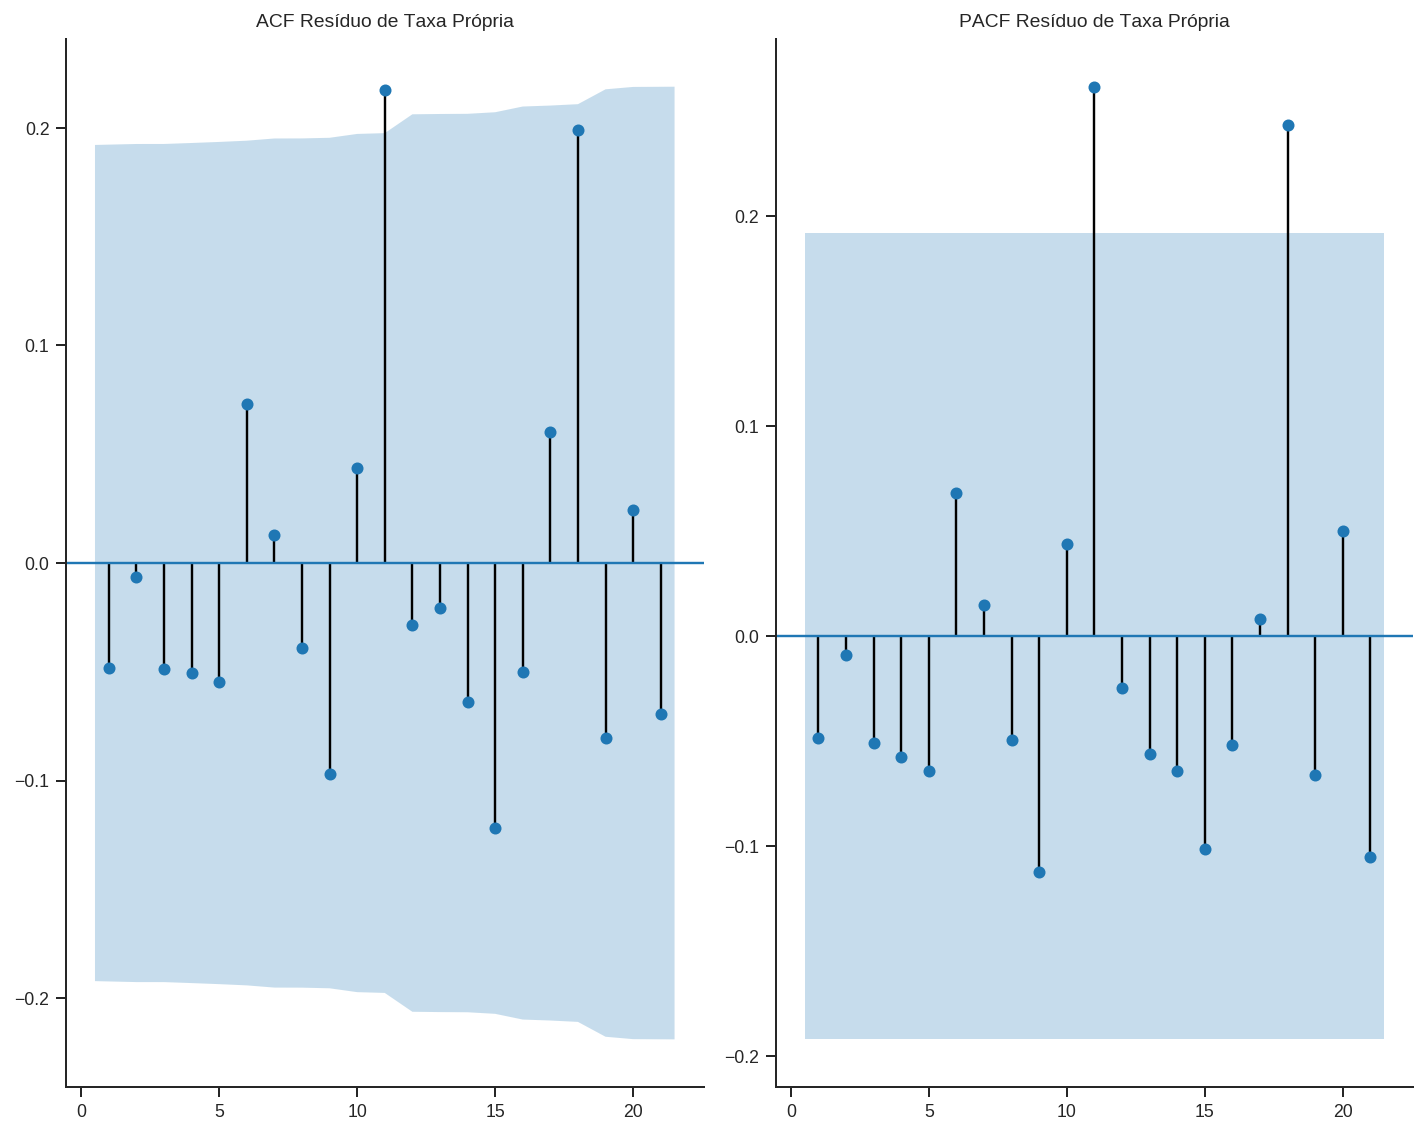

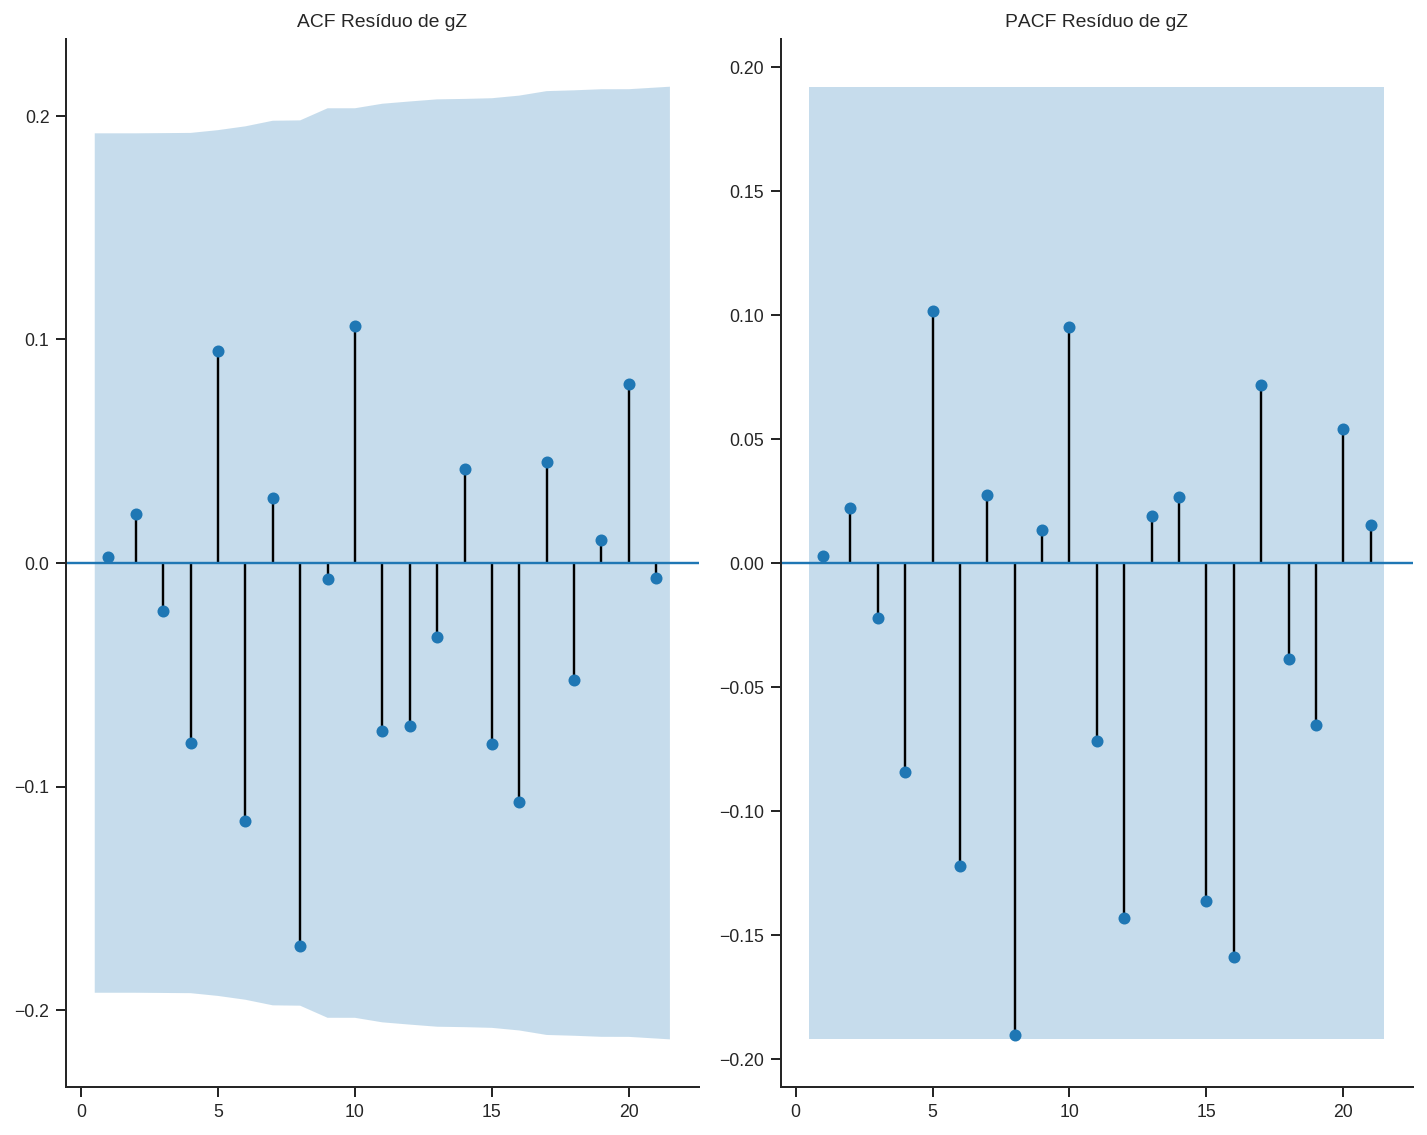

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         47.02          53.38   0.150 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         52.38          53.38   0.060 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
p-value = 0.9771017550896416
Reject H0 on lag  1 ?  False 

p-value = 0.9738708

In [22]:
print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

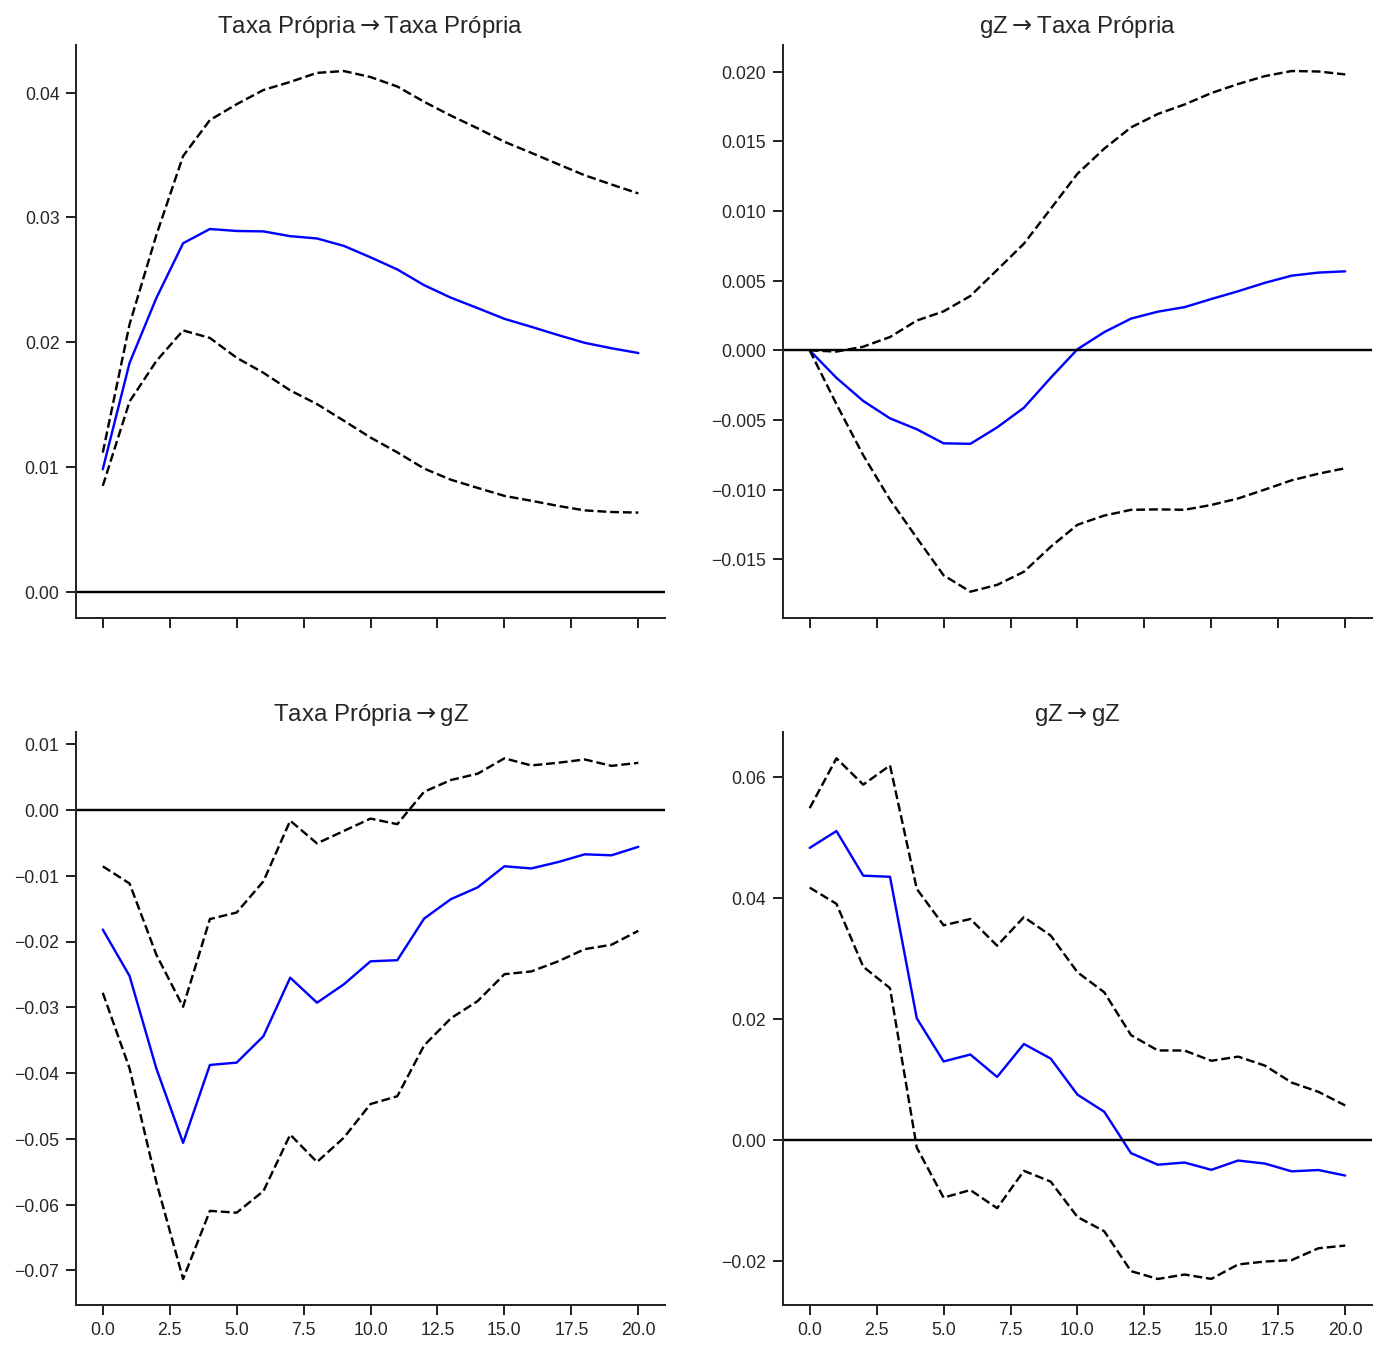

In [23]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

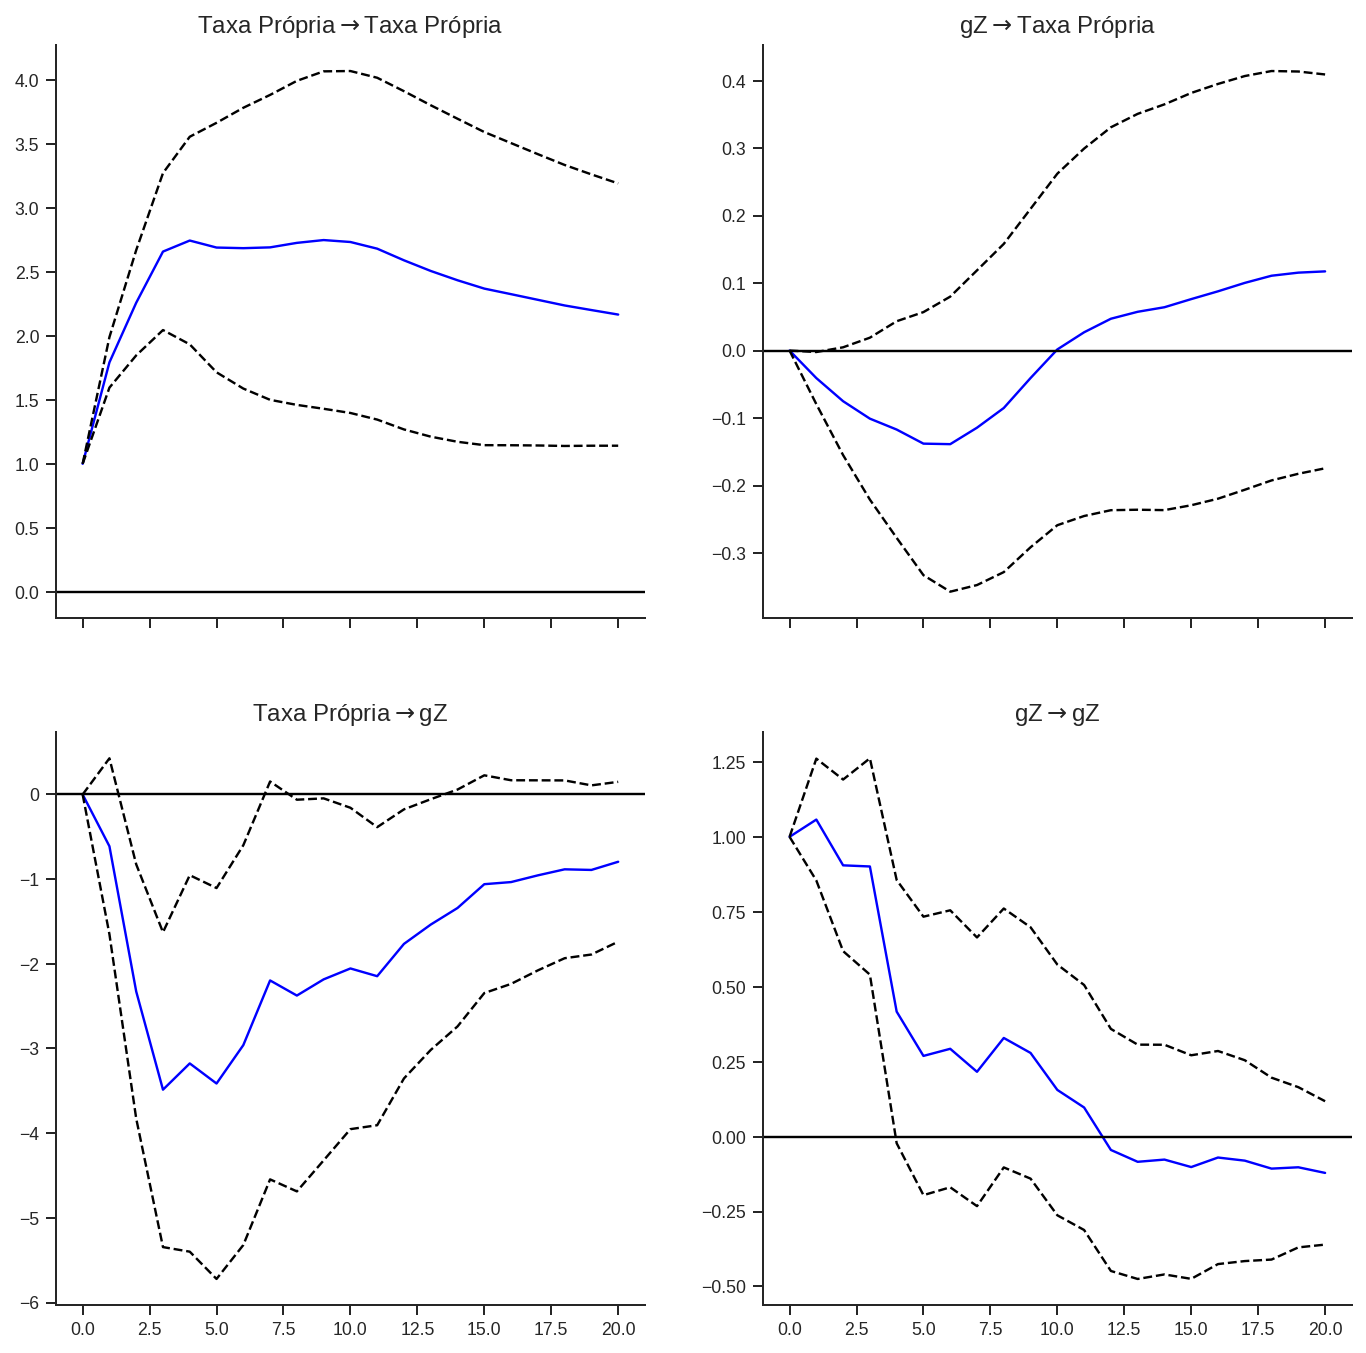

In [24]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Teste de causalidade de granger

In [25]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Taxa Própria does not Granger-cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.294          2.150   0.037 (6, 176)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Taxa Própria does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         11.61          3.841   0.001  1
----------------------------------------


## Inspeção gráfica dos resíduos

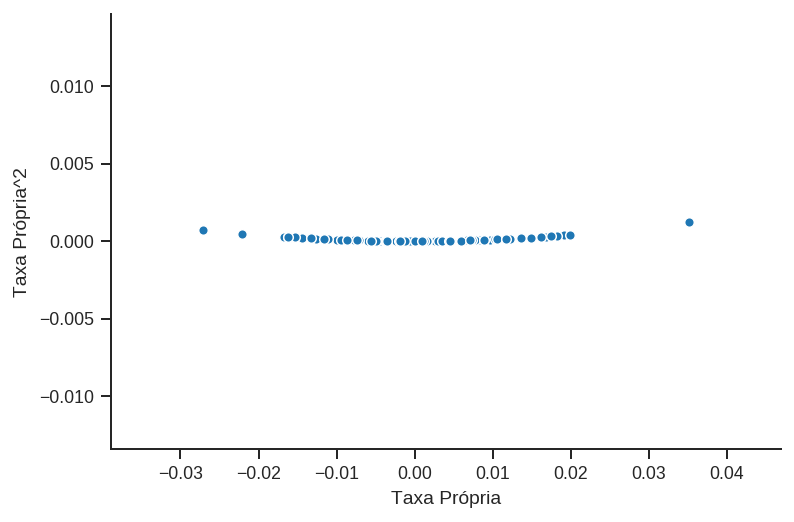

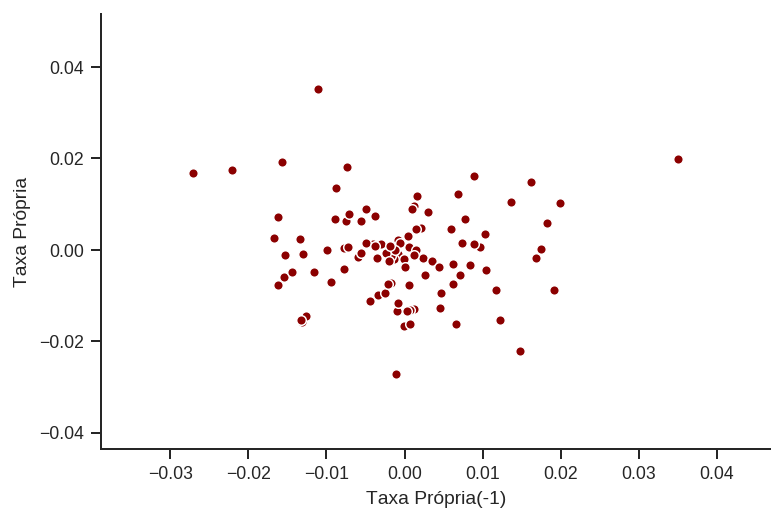

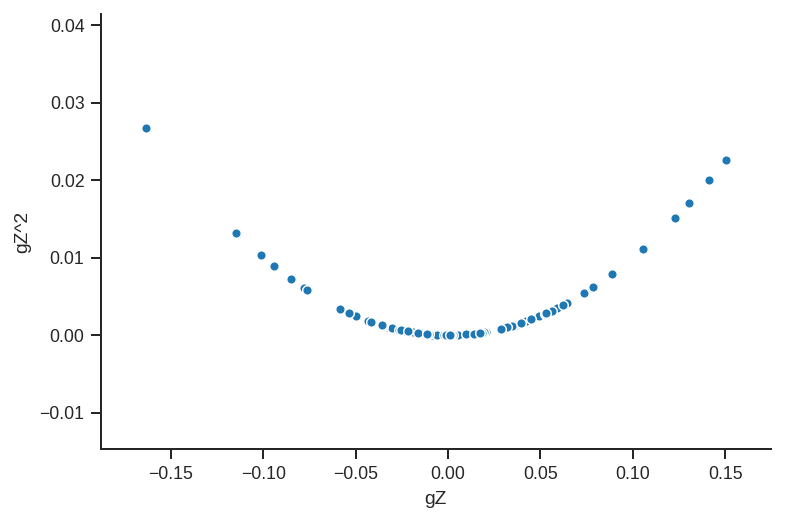

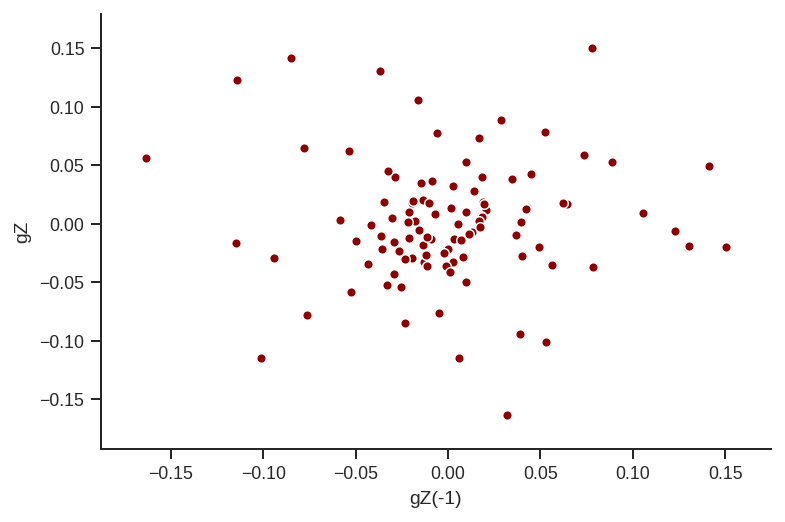

In [26]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

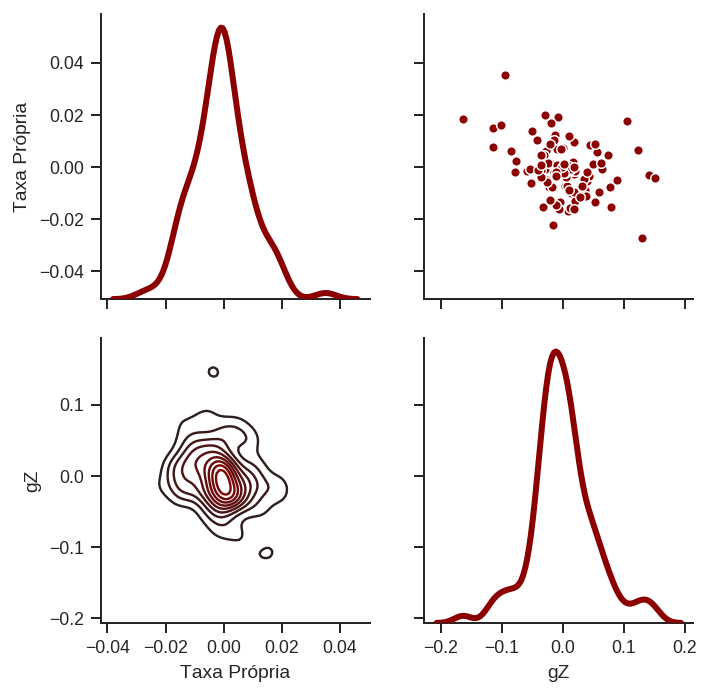

In [27]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

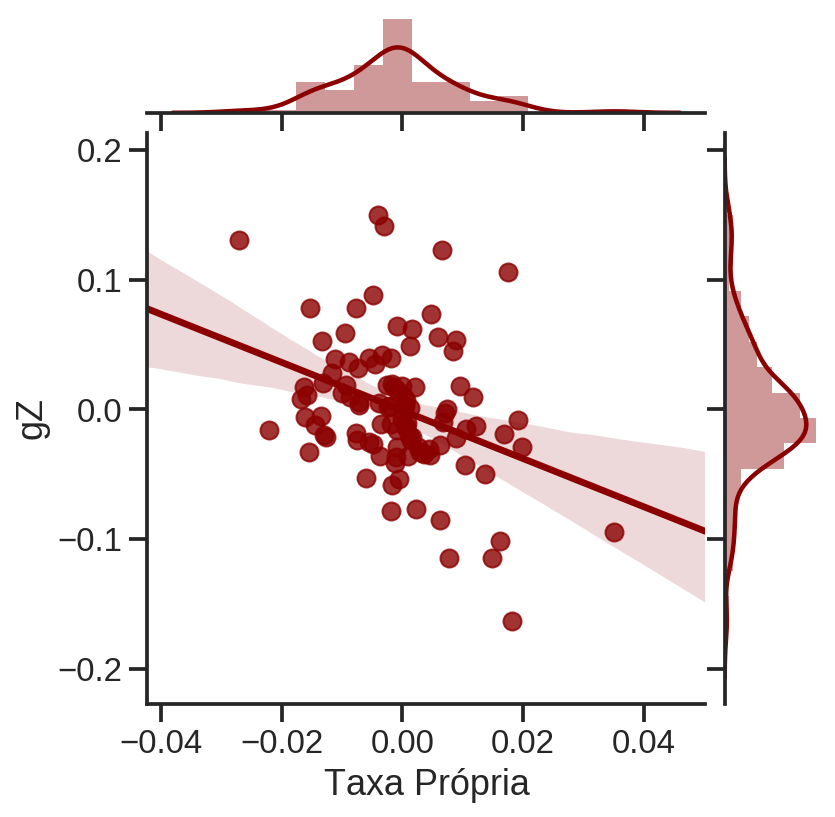

In [28]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

In [29]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(1:4)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("TaxaP","gZ")], lag = 5, r = 1, estim = "ML", include="const")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [30]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

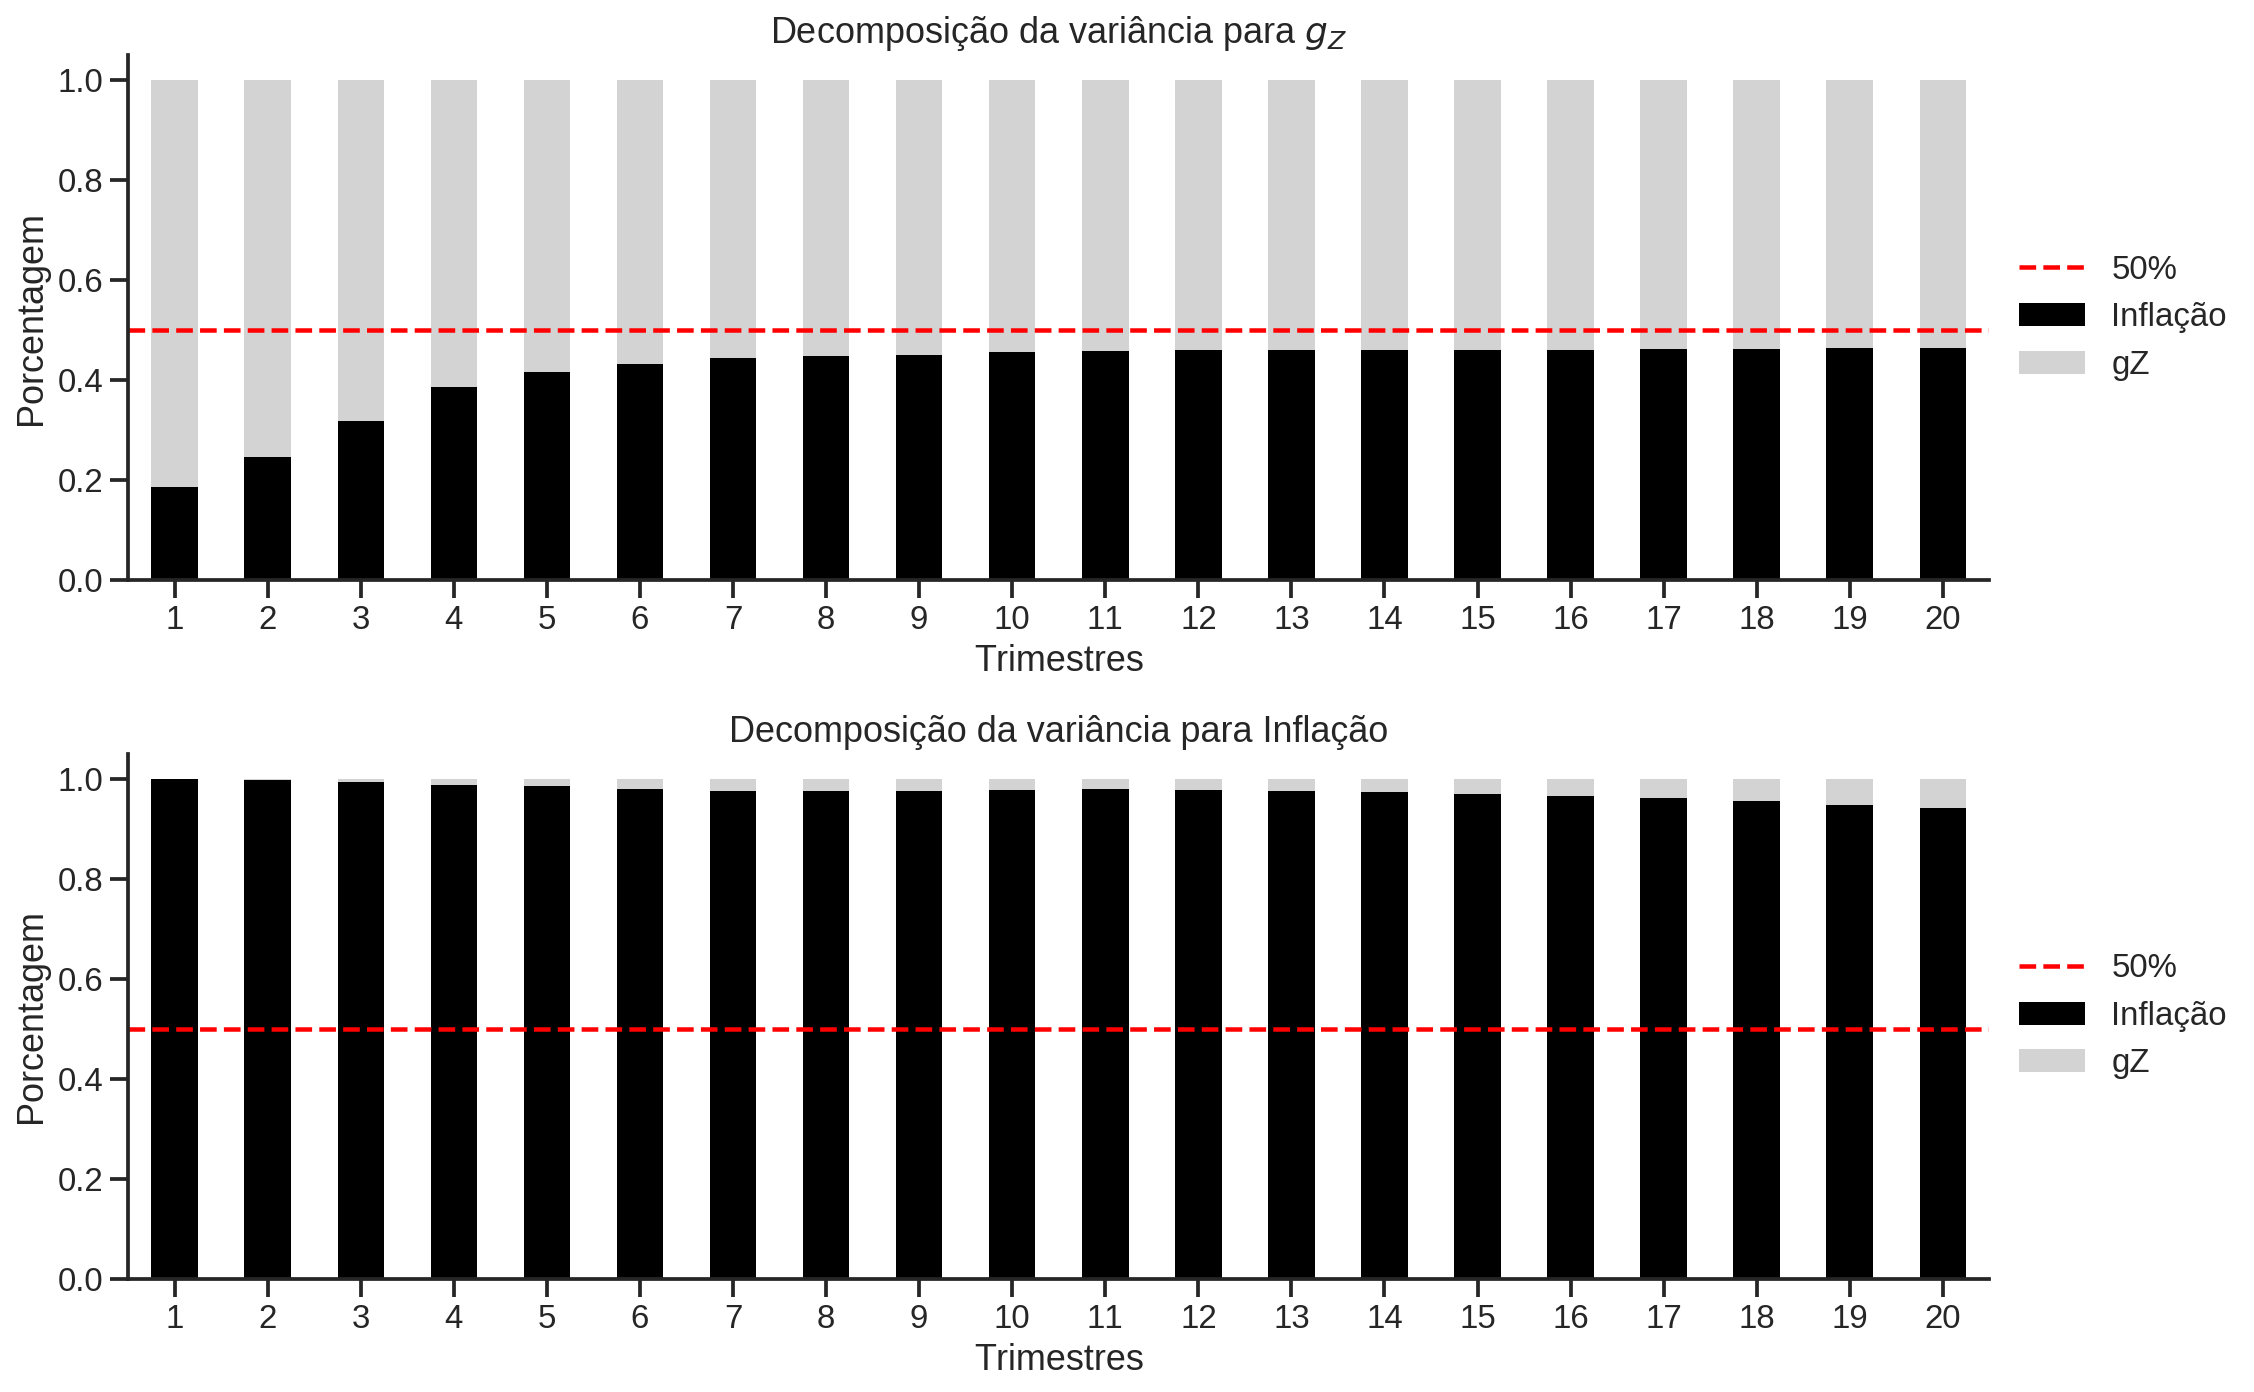

In [31]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [32]:
model = VAR(
    df[["d_Taxa Própria", 'd_gZ']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.78      -13.68   1.031e-06      -13.74
1       -14.56     -14.34*   4.770e-07     -14.47*
2       -14.51      -14.19   4.992e-07      -14.38
3       -14.50      -14.07   5.052e-07      -14.33
4       -14.68      -14.14   4.229e-07      -14.46
5      -14.70*      -14.05  4.146e-07*      -14.44
6       -14.67      -13.92   4.258e-07      -14.37
7       -14.61      -13.75   4.560e-07      -14.26
8       -14.58      -13.62   4.679e-07      -14.19
9       -14.54      -13.46   4.929e-07      -14.10
10      -14.51      -13.32   5.090e-07      -14.03
11      -14.50      -13.21   5.153e-07      -13.98
12      -14.51      -13.11   5.146e-07      -13.94
13      -14.46      -12.95   5.449e-07      -13.85
14      -14.41      -12.80   5.764e-07      -13.76
15      -14.44      -12.72   5.642e-07      -13.75
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [33]:
results = model.fit(maxlags=6)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 10, dez, 2019
Time:                     15:00:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.0991
Nobs:                     104.000    HQIC:                  -14.4924
Log likelihood:           498.391    FPE:                3.89824e-07
AIC:                     -14.7602    Det(Omega_mle):     3.08009e-07
--------------------------------------------------------------------
Results for equation d_Taxa Própria
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000685         0.001032           -0.663           0.507
L1.d_Taxa Própria         0.736776         0.110804            6.649           0.000
L1.d_gZ                  -0.047744 

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

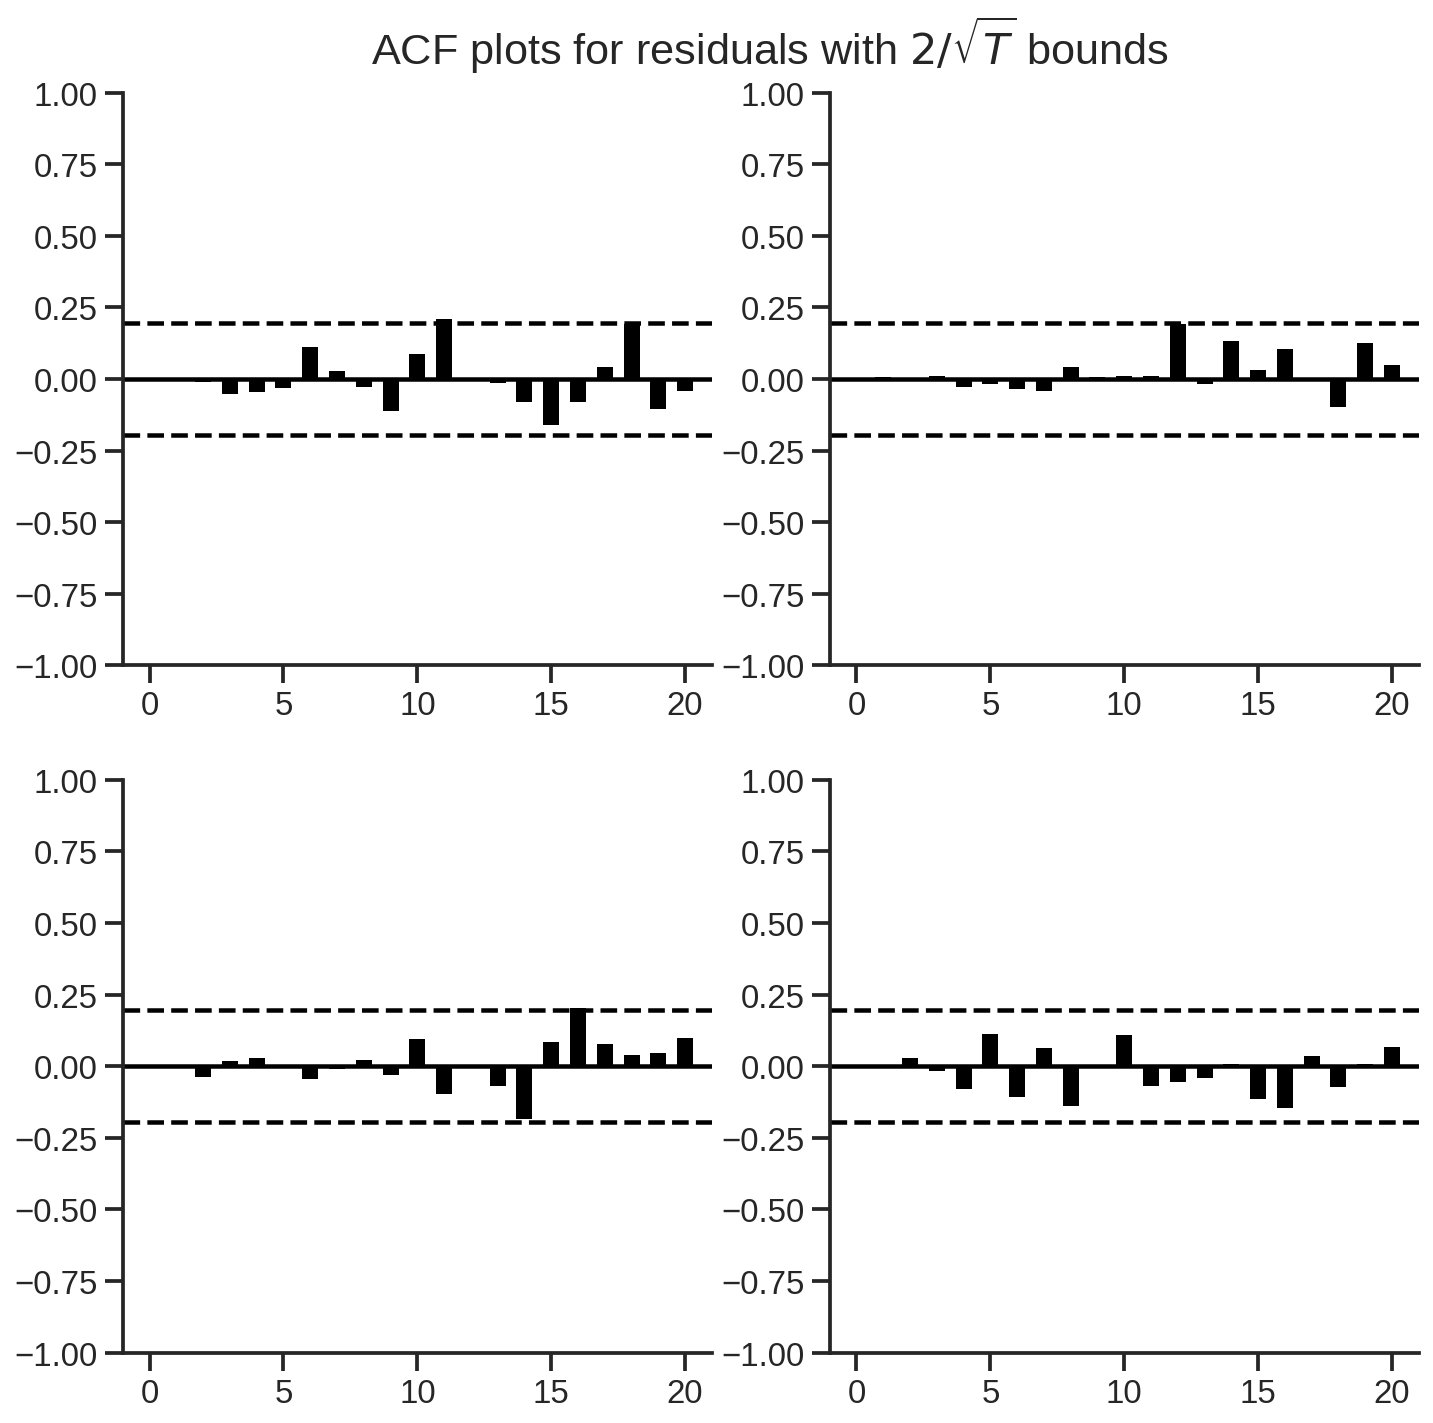

In [34]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [35]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.8623308076040799
0.8623308076040799
0.5498482155607752
0.5498482155607752
0.6641401663864567
0.6641401663864567
0.8796407604004912
0.8796407604004912
0.7875166906977872
0.7875166906977872
0.598197247206872
0.598197247206872
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

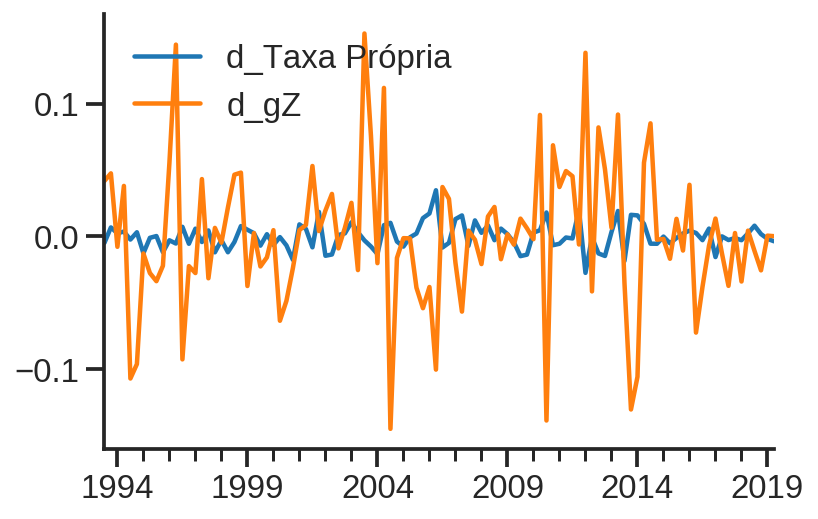

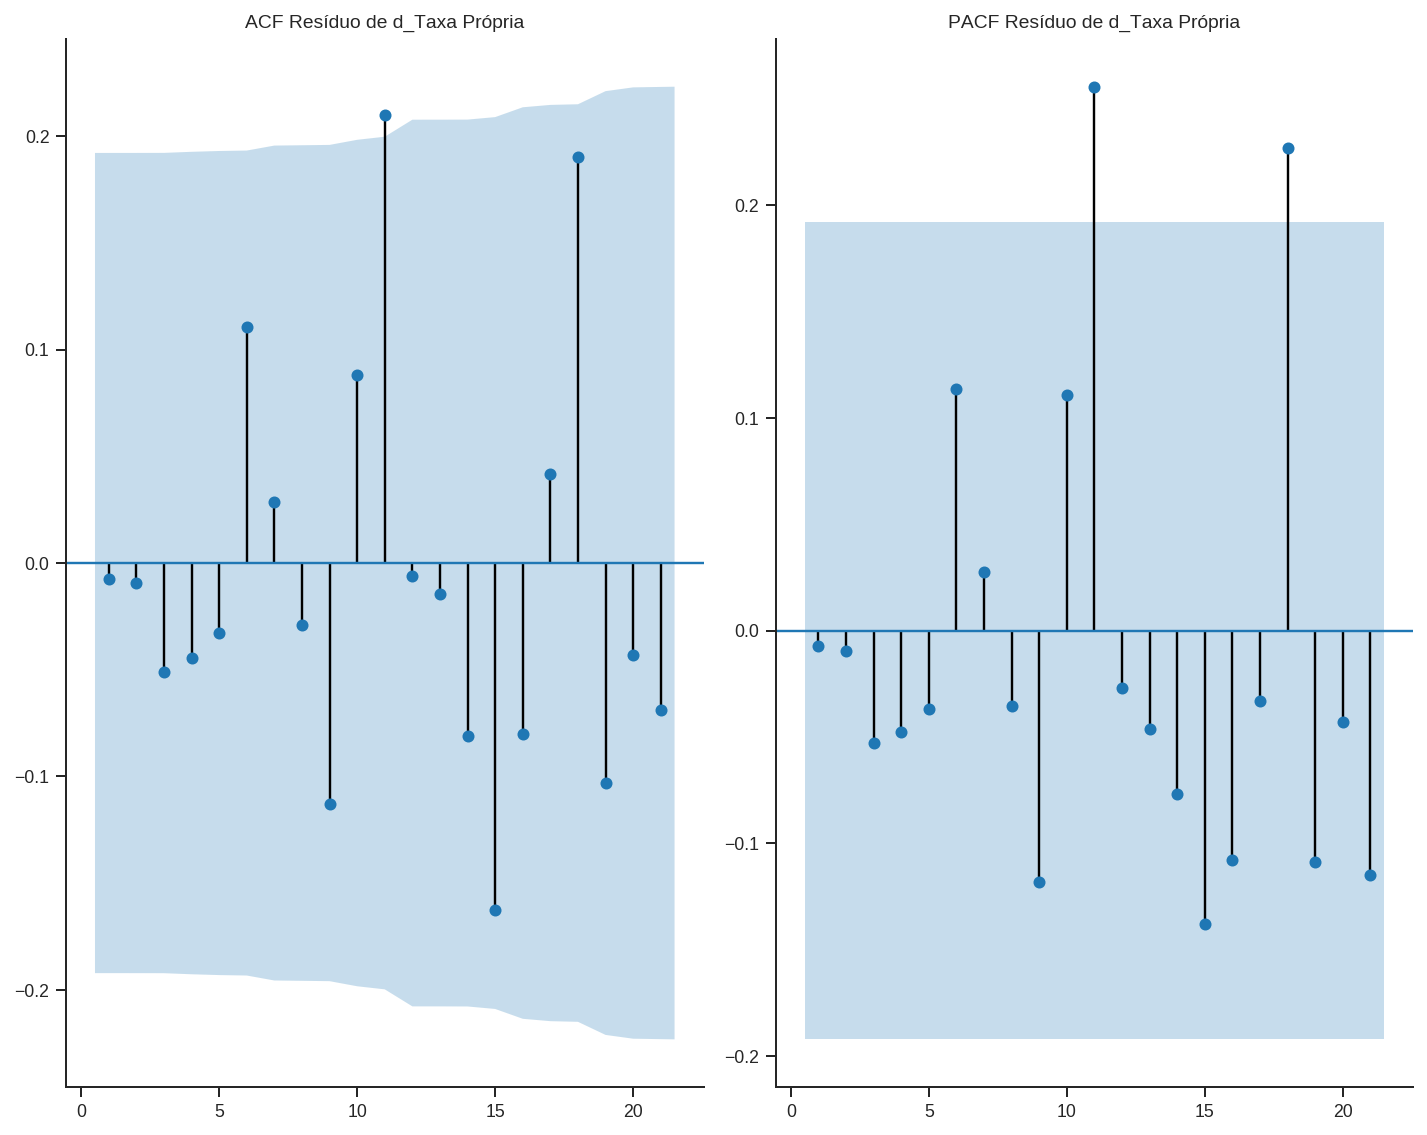

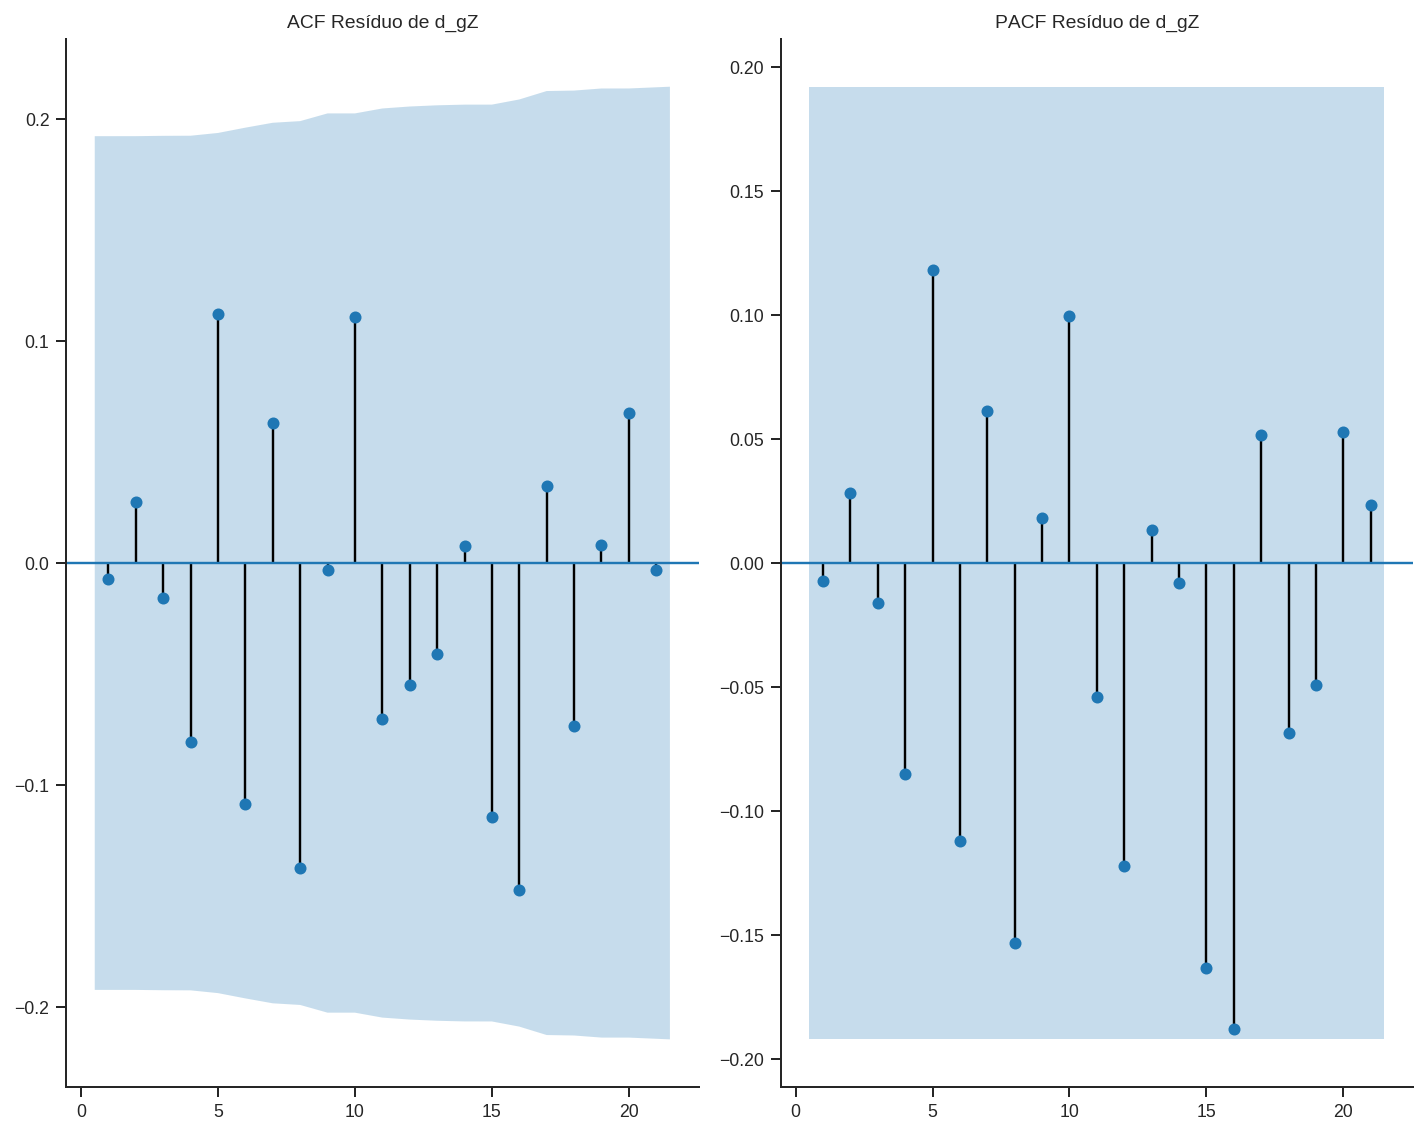

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         42.33          51.00   0.217 36
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         47.22          51.00   0.100 36
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_TAXA PRÓPRIA . Considering a significance level of 5.0 %
p-value = 0.9395833969440968
Reject H0 on lag  1 ?  False 

p-value = 0.95662

In [36]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

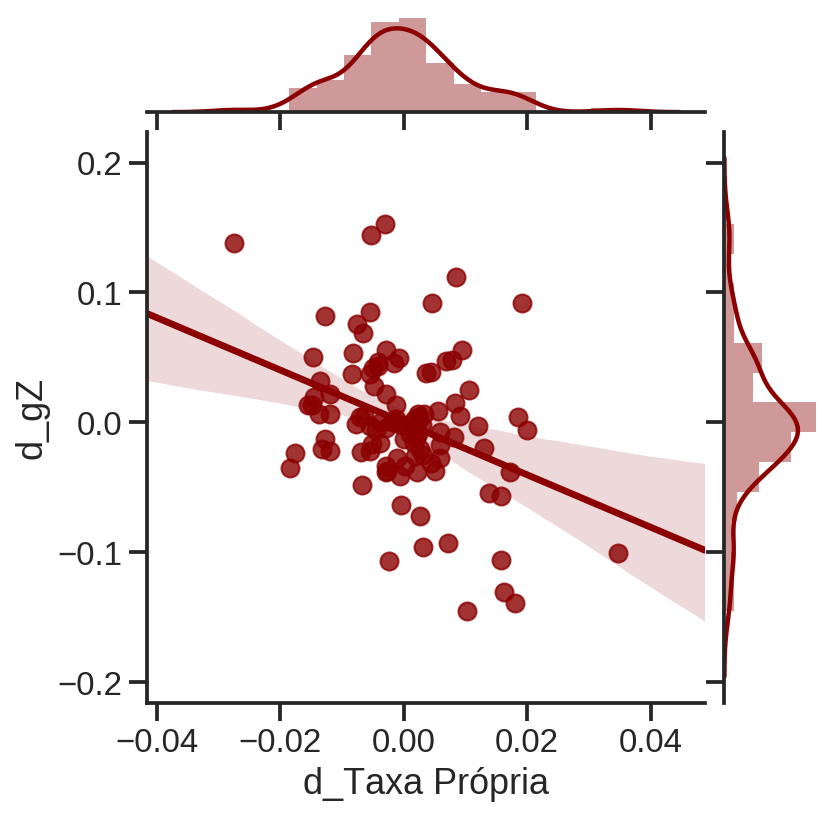

In [37]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

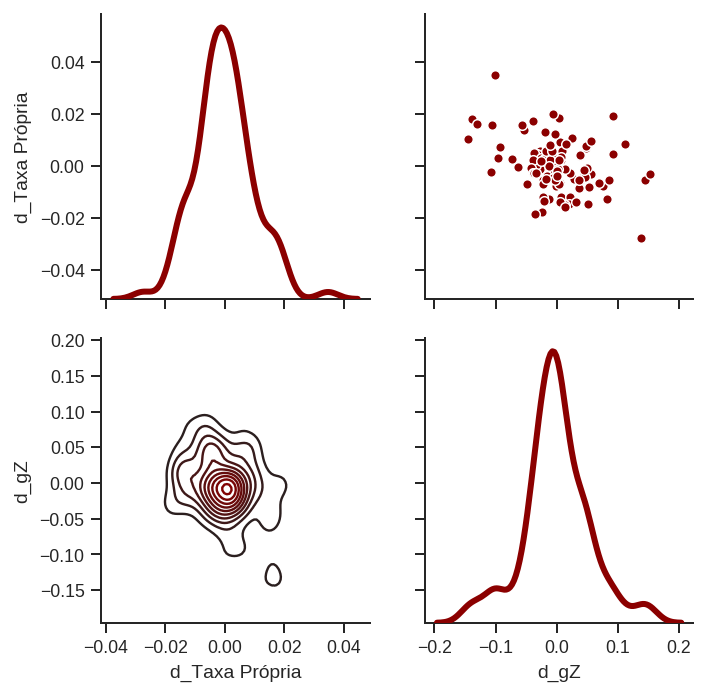

In [38]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

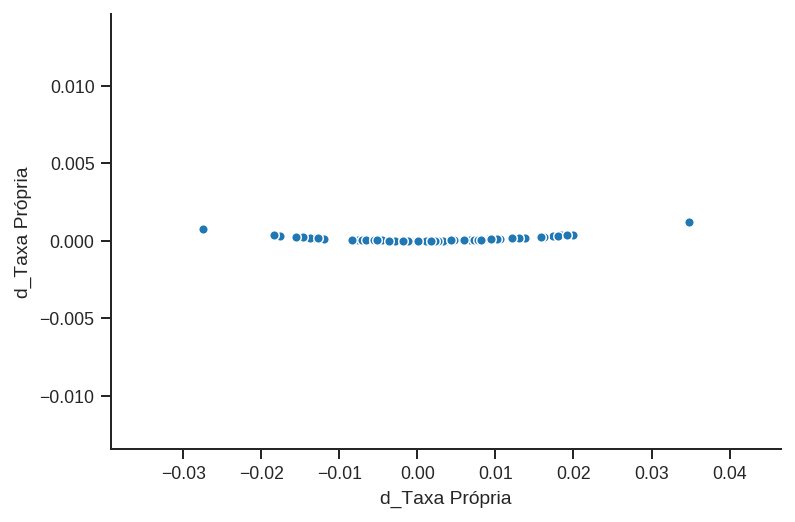

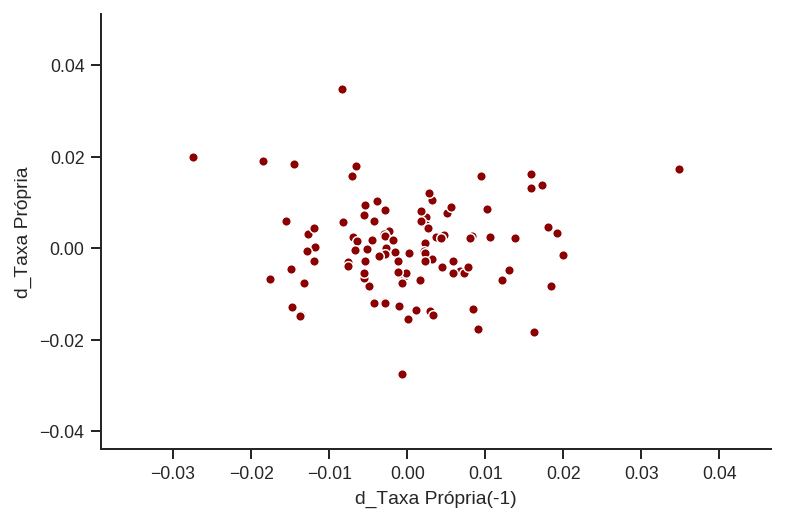

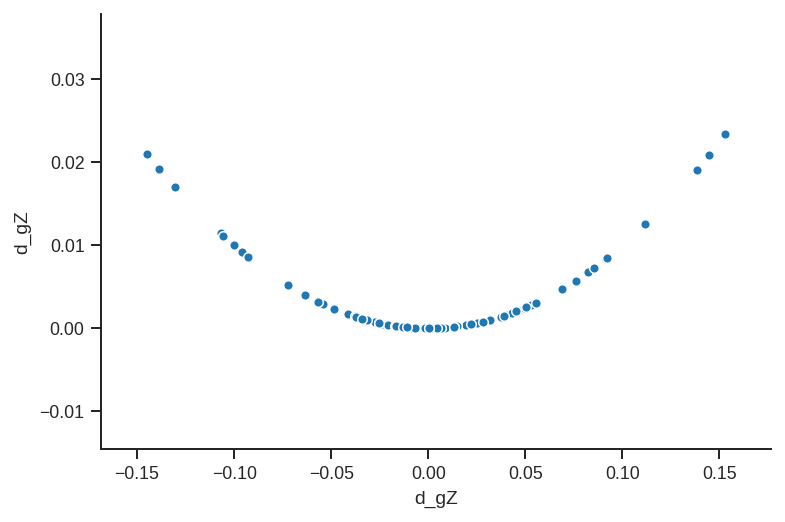

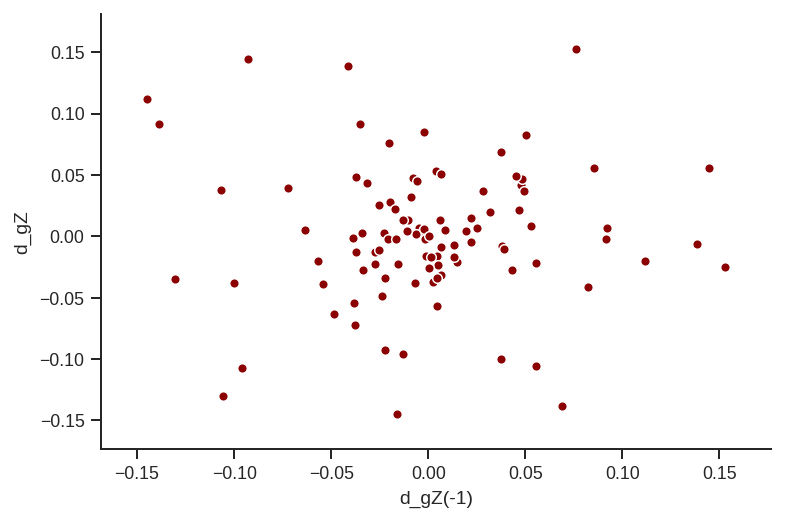

In [39]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

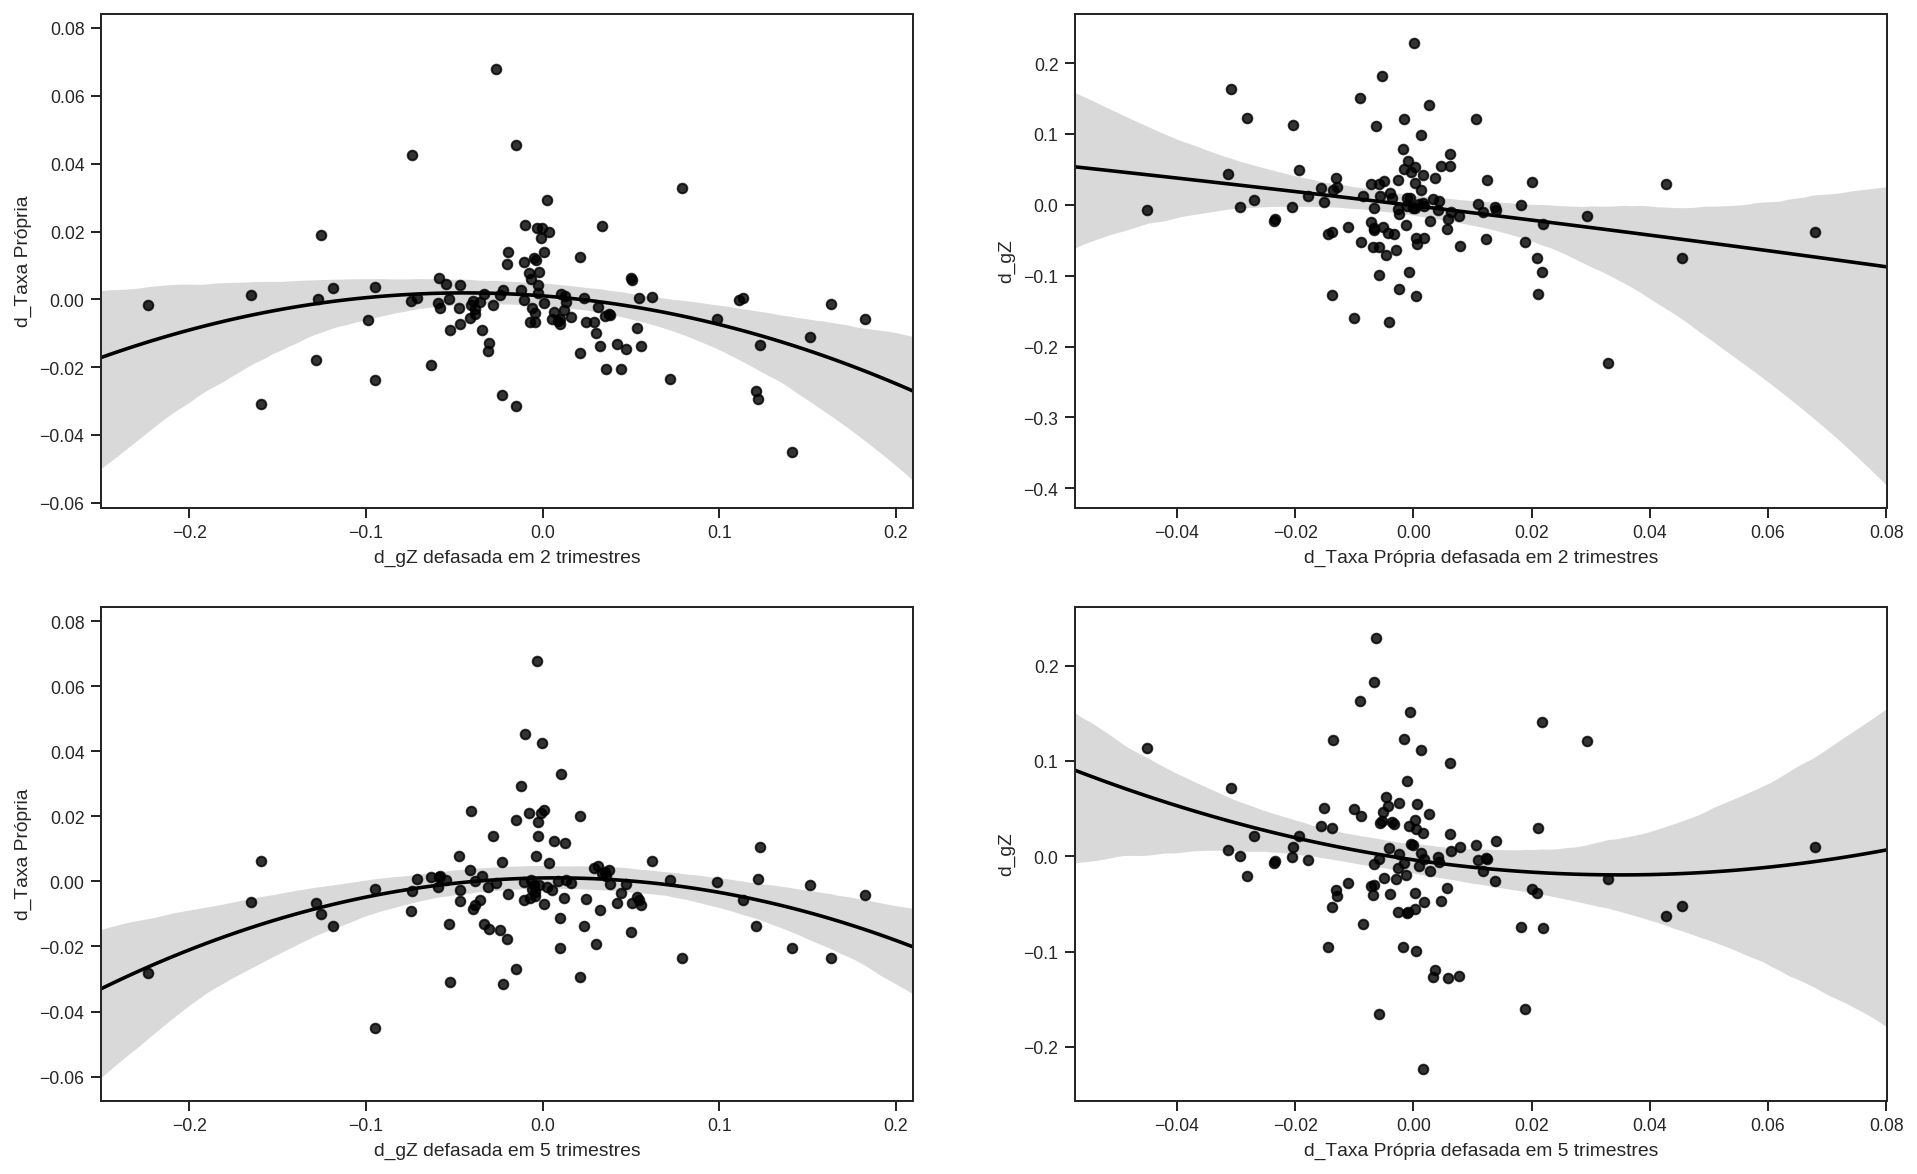

In [40]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

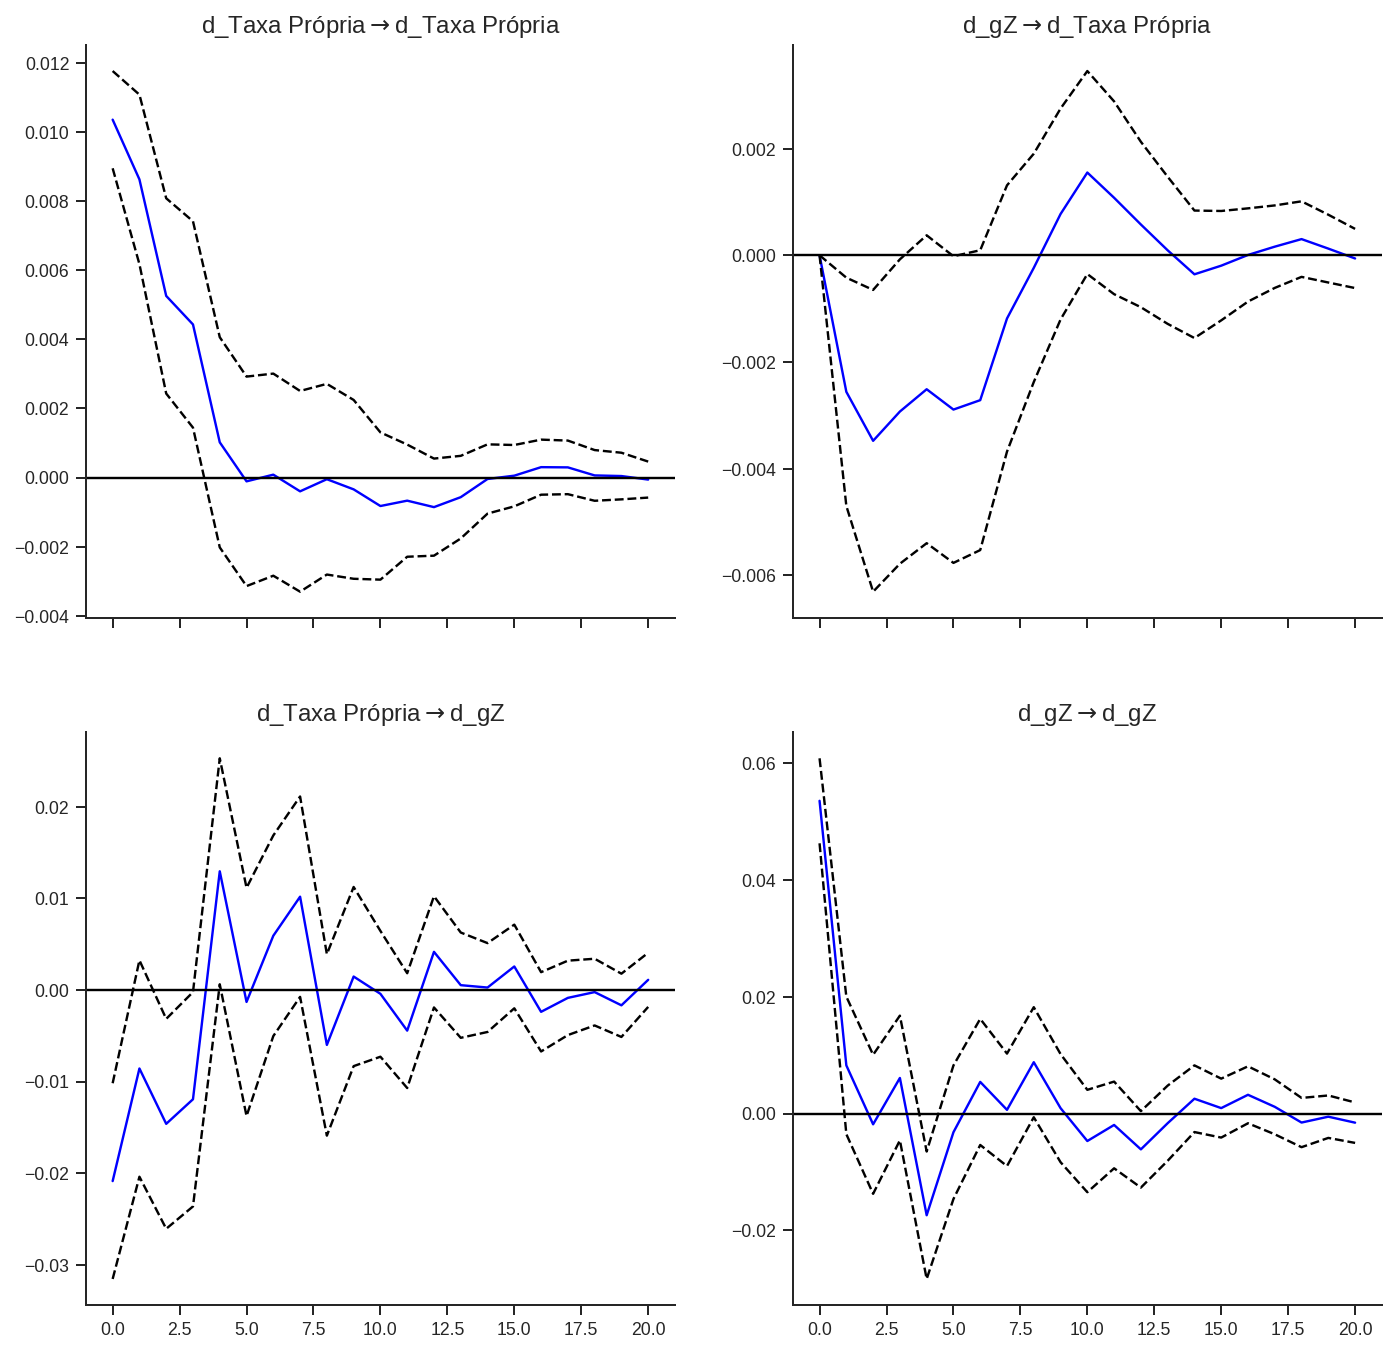

In [41]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

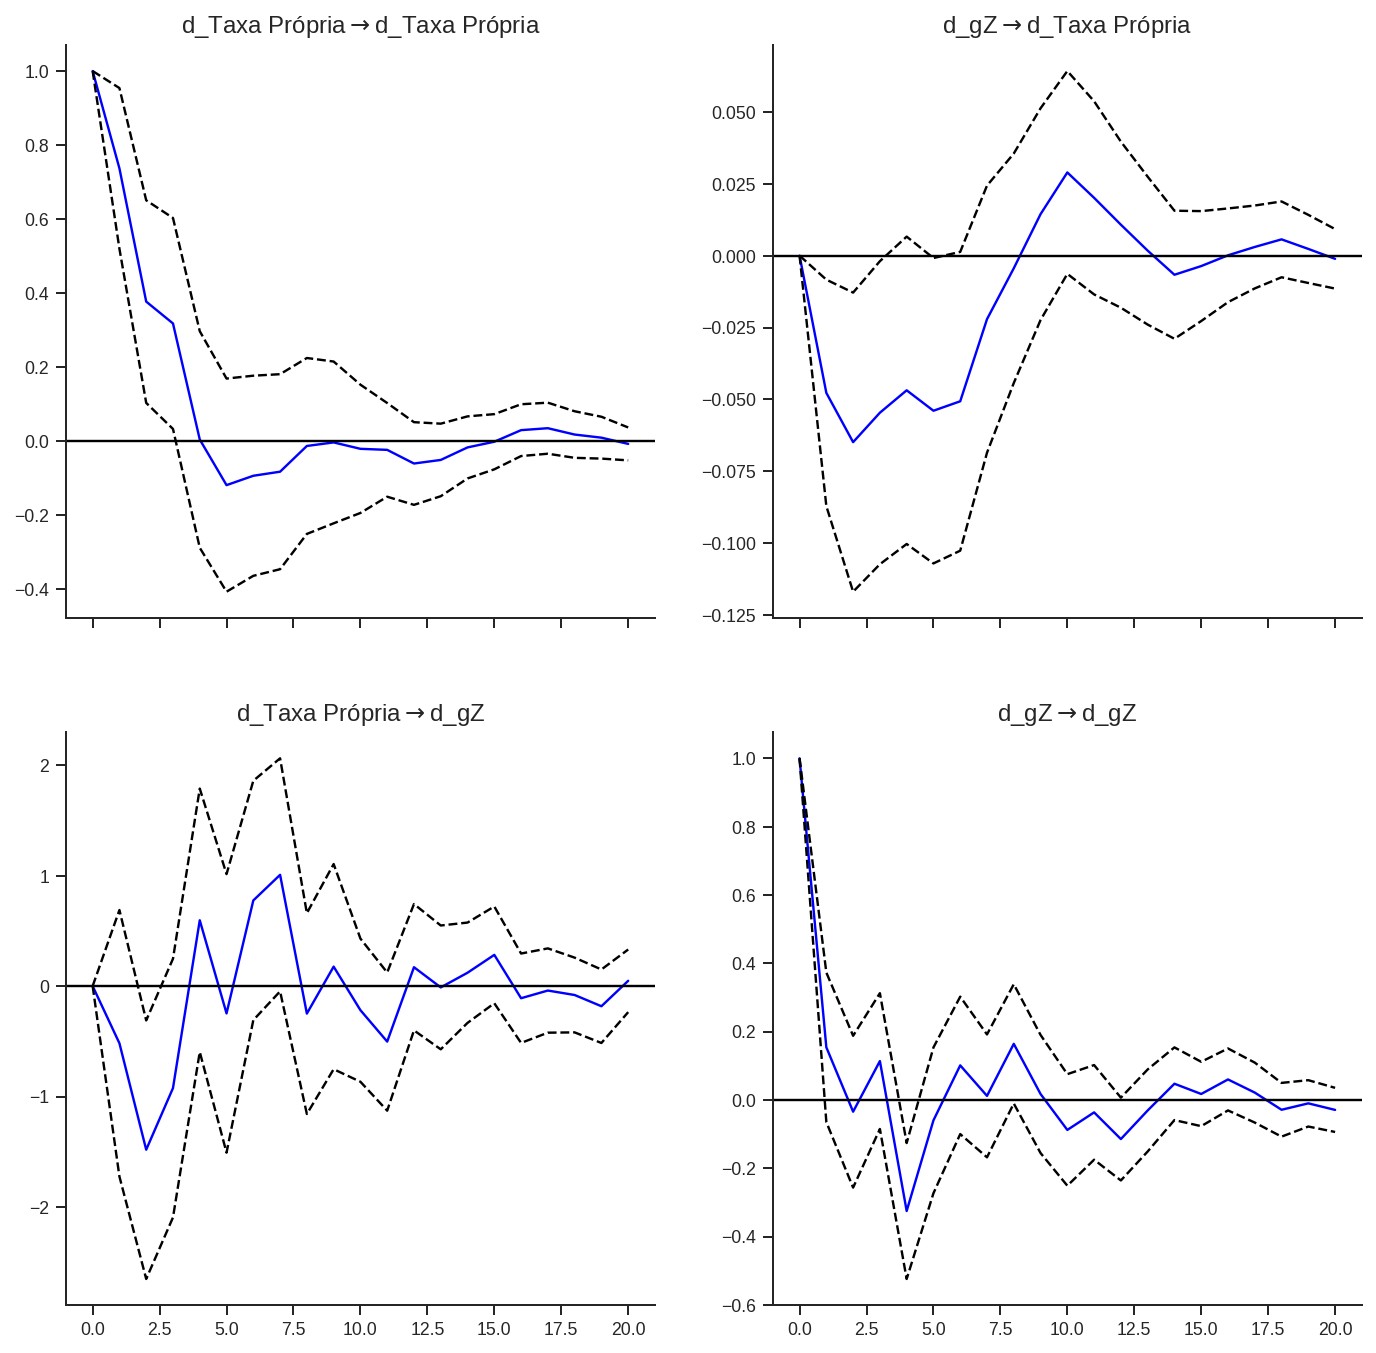

In [42]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

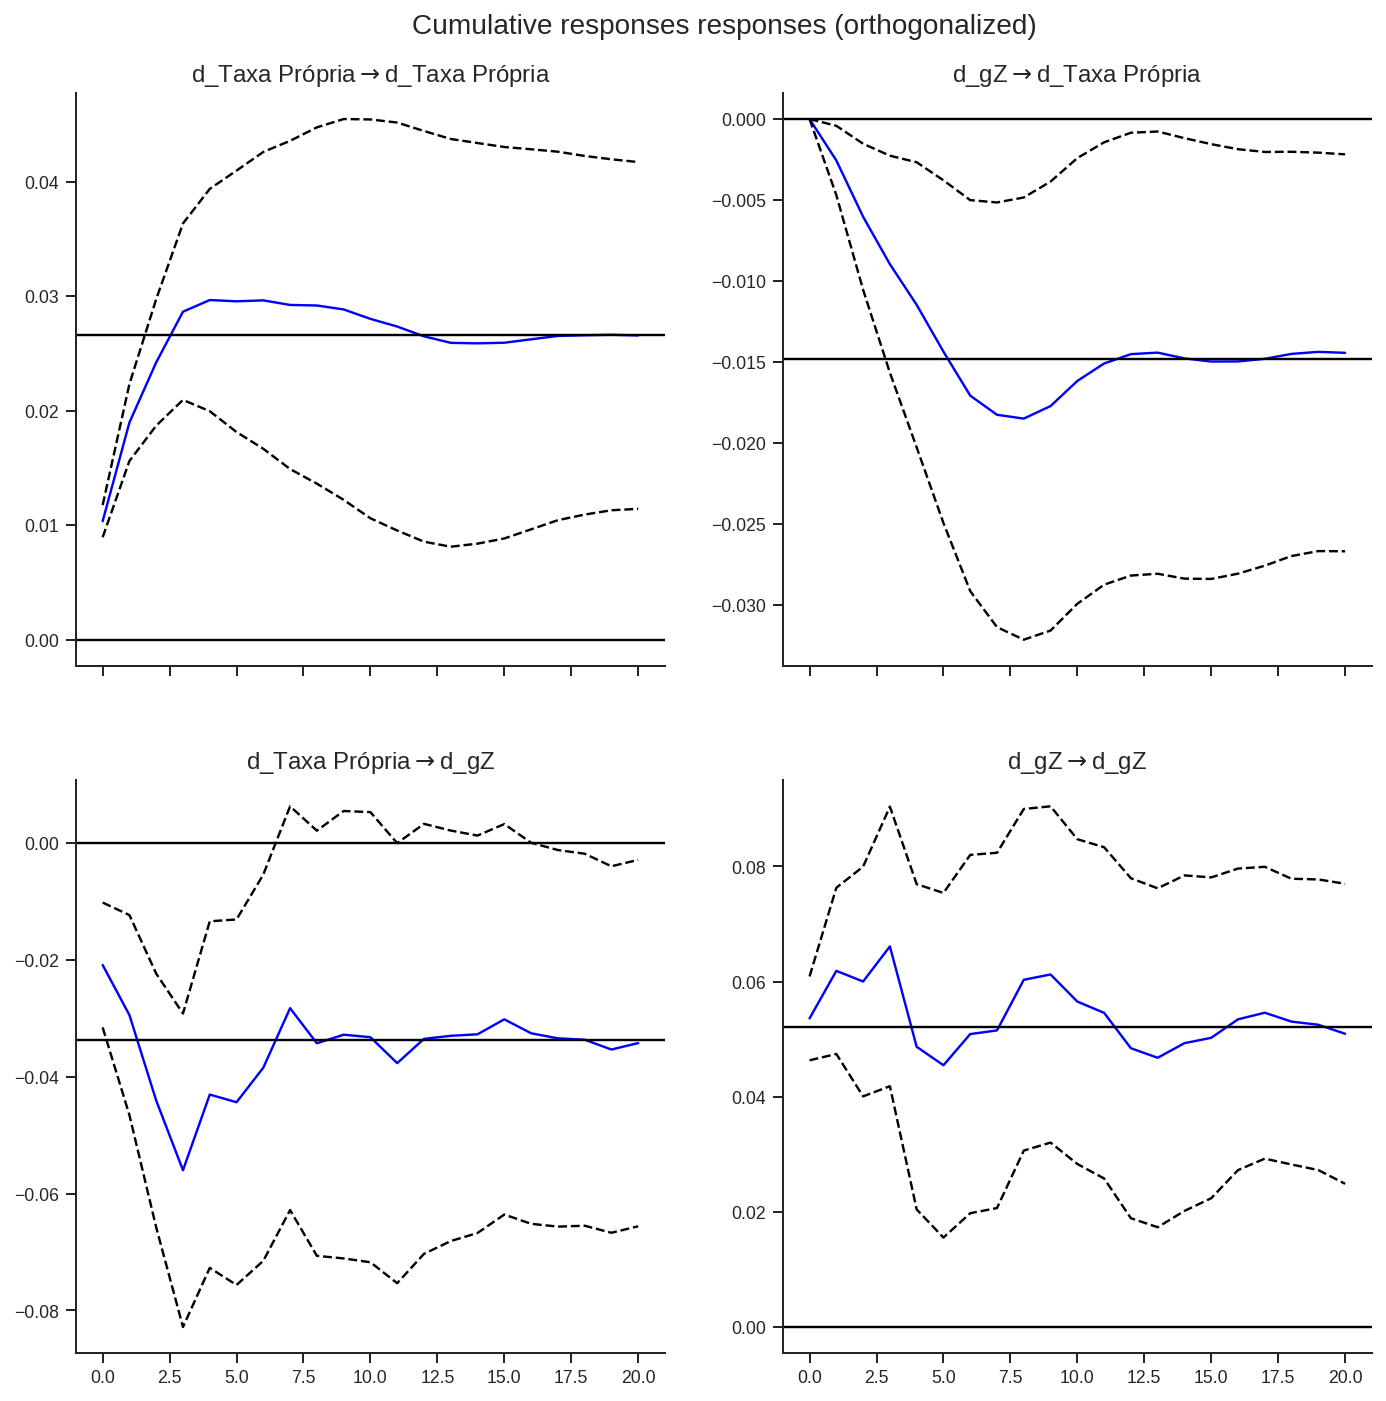

In [43]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

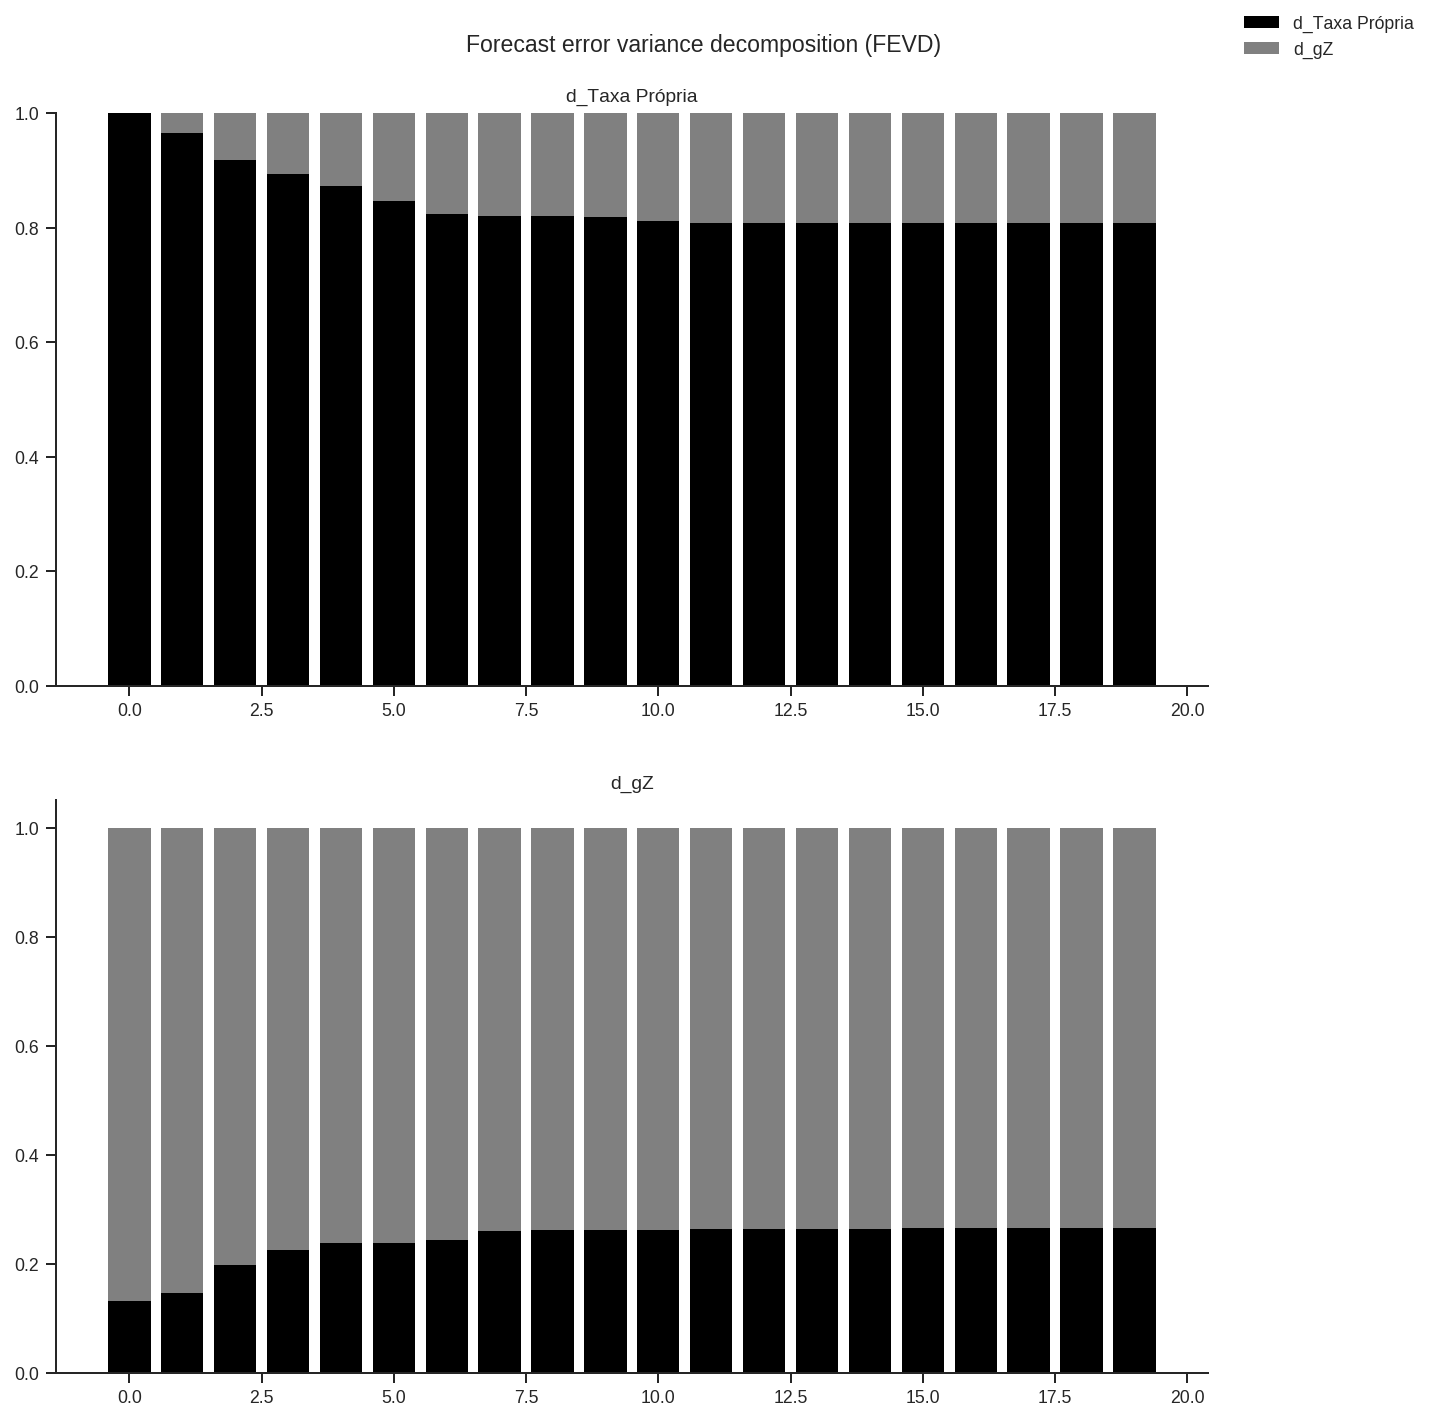

In [44]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)